### Import the pretrained DNABERT2 model

In [ ]:
# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModel

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the model and tokenizer
def load_dnabert():
    try:
        # For transformers version 4.28
        tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
        model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
    except:
        # For transformers version > 4.28
        from transformers.models.bert.configuration_bert import BertConfig
        config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
        tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
        model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config)
    
    model = model.to(device)
    return tokenizer, model

tokenizer, model = load_dnabert()

# Function to get embeddings for a DNA sequence
def get_dna_embeddings(sequence, model, tokenizer):
    # Tokenize the sequence
    inputs = tokenizer(sequence, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(inputs['input_ids'])
    hidden_states = outputs[0]
    
    # Calculate embeddings using both pooling methods
    embedding_mean = torch.mean(hidden_states[0], dim=0)
    embedding_max = torch.max(hidden_states[0], dim=0)[0]
    
    return embedding_mean, embedding_max

# Test the model with an example sequence
example_dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
emb_mean, emb_max = get_dna_embeddings(example_dna, model, tokenizer)

print("Mean pooling embedding shape:", emb_mean.shape)
print("Max pooling embedding shape:", emb_max.shape)

# Example of how to use the embeddings for multiple sequences
def process_multiple_sequences(sequences):
    results = []
    for seq in sequences:
        emb_mean, emb_max = get_dna_embeddings(seq, model, tokenizer)
        results.append({
            'sequence': seq,
            'mean_embedding': emb_mean.cpu().numpy(),
            'max_embedding': emb_max.cpu().numpy()
        })
    return results

# Test with multiple sequences
test_sequences = [
    "ACGTAGCATCGGAT",
    "TCTATCTATCGACA",
    "CTTGGTTATCGATC"
]

results = process_multiple_sequences(test_sequences)
print(f"\nProcessed {len(results)} sequences successfully!")

In [ ]:
# %% cell 3 code
import time
import random

# Generate a large random DNA sequence (1000 bases)
bases = ['A', 'C', 'G', 'T']
large_dna_sequence = "".join(random.choice(bases) for _ in range(1000))
print(f"Generated a DNA sequence of length: {len(large_dna_sequence)}")

# Measure inference time
start_time = time.time()
emb_mean_large, emb_max_large = get_dna_embeddings(large_dna_sequence, model, tokenizer)
end_time = time.time()

duration = end_time - start_time

print(f"\nInference for {len(large_dna_sequence)} bases took: {duration:.4f} seconds")
print("Mean pooling embedding shape:", emb_mean_large.shape)
print("Max pooling embedding shape:", emb_max_large.shape)


### Pepare the labeled dataset

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/home/youss/DNA-bert/SLC19A3_MUTATIONS_10K_Context.csv'
df = pd.read_csv(file_path)

# Print the head of the dataframe
print("DataFrame Head:")
print(df.head())


In [ ]:
# Define the path to the sequence file
file_path = 'wild_type_sequence.txt'

# Read the sequence from the file
try:
    with open(file_path, 'r') as f:
        wild_type_sequence = f.read().strip() # Read the whole file and remove leading/trailing whitespace

    # Print the length of the sequence
    print(f"Length of the wild type sequence: {len(wild_type_sequence)}")
    # Optionally, print the sequence itself if it's not too long
    # print(f"Wild type sequence: {wild_type_sequence}")

except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import pandas as pd

# Read the wild type sequence
# Create a copy of the dataframe to avoid modifying the original
df_wild = df.copy()

# Replace sequences where clinical_significance is 'normal' with wild type sequence
df_wild.loc[df_wild['clinical_significance'] == 'normal', 'sequence'] = wild_type_sequence

# Save the modified dataframe
df_wild.to_csv('df_wild.csv', index=False)

print("Number of sequences replaced:", (df_wild['clinical_significance'] == 'normal').sum())
print("Total rows in dataframe:", len(df_wild))

In [ ]:
import pandas as pd
import copy

def process_variants(df_wild, wild_type_sequence, gene_start=227683763):
    # Create a new dataframe for the modified sequences
    df_processed = df_wild.copy()
    
    # Process only non-normal variants
    mask = df_processed['clinical_significance'] != 'normal'
    
    for idx, row in df_processed[mask].iterrows():
        try:
            # Calculate local position in the gene
            var_local_pos = row['pos'] - gene_start  # -1 for zero-based indexing
            
            # Check if the position is within the bounds of the sequence
            if var_local_pos < 0 or var_local_pos >= len(wild_type_sequence):
                print(f"Warning: Position {var_local_pos} is out of range for sequence of length {len(wild_type_sequence)}. Skipping variant at position {row['pos']}.")
                continue
            
            if row['variant_type'].lower() == 'snv':
                # Handle SNV (Single Nucleotide Variant)
                ref, alts = row['variation'].split('>')
                alts = alts.split(',')  # Split multiple alternative alleles
                
                # Verify reference base
                if wild_type_sequence[var_local_pos] == ref:
                    # Create a row for each alternative allele
                    for alt in alts:
                        if alt != '-':  # Skip if it's a deletion marker
                            new_seq = list(wild_type_sequence)
                            new_seq[var_local_pos] = alt
                            df_processed.at[idx, 'sequence'] = ''.join(new_seq)
                            # If there are multiple alternatives, we need to duplicate the row
                            if len(alts) > 1 and alt != alts[0]:
                                new_row = df_processed.loc[idx].copy()
                                new_row['sequence'] = ''.join(new_seq)
                                df_processed = pd.concat([df_processed, pd.DataFrame([new_row])], ignore_index=True)
                else:
                    print(f"Warning: Reference base mismatch at position {var_local_pos}. Expected {ref}, found {wild_type_sequence[var_local_pos]}")
            
            elif row['variant_type'].lower() == 'delins':
                # Handle deletion-insertion variants
                if '>' in row['variation']:
                    ref, alt = row['variation'].split('>')
                    new_seq = list(wild_type_sequence)
                    
                    if ref == '-':  # Insertion
                        # Insert the new sequence at the position
                        new_seq = new_seq[:var_local_pos] + list(alt) + new_seq[var_local_pos:]
                    elif alt == '-':  # Deletion
                        # Remove the sequence
                        new_seq = new_seq[:var_local_pos] + new_seq[var_local_pos + len(ref):]
                    else:  # Replacement
                        new_seq = new_seq[:var_local_pos] + list(alt) + new_seq[var_local_pos + len(ref):]
                    
                    df_processed.at[idx, 'sequence'] = ''.join(new_seq)
            
            elif row['variant_type'].lower() == 'mnv':
                # Handle Multiple Nucleotide Variants
                ref, alt = row['variation'].split('>')
                new_seq = list(wild_type_sequence)
                # Replace the sequence at the position
                if var_local_pos + len(ref) <= len(wild_type_sequence):
                    new_seq[var_local_pos:var_local_pos + len(ref)] = list(alt)
                    df_processed.at[idx, 'sequence'] = ''.join(new_seq)
                else:
                    print(f"Warning: MNV at position {var_local_pos} extends beyond sequence length. Skipping.")
        
        except Exception as e:
            print(f"Error processing variant at position {row['pos']}: {e}. Skipping.")
            continue

    return df_processed


# Process the variants
try:
    df_processed = process_variants(df_wild, wild_type_sequence)
    
    # Save the processed dataframe
    df_processed.to_csv('df_processed.csv', index=False)
    
    # Print statistics
    print("Number of variants processed:", len(df_processed) - len(df_wild))
    print("Total rows in processed dataframe:", len(df_processed))
except Exception as e:
    print(f"Error during variant processing: {e}")

In [ ]:
df_processed.head()

### Generating Embeddings

In [ ]:
# gener

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported if pd.isna is used

# Ensure df_processed exists from the previous cell
if 'df_processed' not in locals():
    raise NameError("df_processed is not defined. Please run the previous cell to generate it.")
# Ensure get_dna_embeddings, model, and tokenizer are defined
if 'get_dna_embeddings' not in locals() or 'model' not in locals() or 'tokenizer' not in locals():
     raise NameError("get_dna_embeddings, model, or tokenizer is not defined. Please ensure they are loaded.")


# --- 1. Generate Embeddings using df_processed (Splitting Sequences) ---
print("Generating embeddings for processed sequences (splitting into 5 parts)...")
combined_embeddings_list_nn = []
labels_list_nn = []
sequences_list_nn = [] # Keep track of original sequences corresponding to embeddings
num_parts = 5
embedding_dim_per_part = -1 # Will be determined by the first successful embedding

# Use mean pooling embeddings for this task (applied to each part)
embedding_type_nn = 'mean' # or 'max' or 'concatenate'

# Limit the number of sequences for faster testing/debugging if needed
# df_subset_nn = df_processed.head(200) # Uncomment for testing
df_subset_nn = df_processed

# Assuming get_dna_embeddings, model, and tokenizer are defined from earlier cells
for index, row in tqdm(df_subset_nn.iterrows(), total=df_subset_nn.shape[0], desc="Processing sequences for NN"):
    sequence = row['sequence']
    label = row['ContinuousLabel'] # Assuming this is the correct label column

    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid sequence '{sequence}'")
        continue

    # Ensure label is valid (e.g., not NaN)
    if pd.isna(label):
        print(f"Skipping row {index}: Invalid label '{label}'")
        continue

    # Ensure sequence is long enough to be split (optional, depends on desired handling)
    min_len_per_part = 10 # Example minimum length for a part to be meaningful
    if len(sequence) < num_parts * min_len_per_part:
        print(f"Skipping row {index}: Sequence too short ({len(sequence)} bases) to split into {num_parts} parts of min length {min_len_per_part}.")
        continue

    part_embeddings = []
    try:
        # Split sequence into num_parts roughly equal parts
        seq_len = len(sequence)
        part_len = seq_len // num_parts
        start_indices = [i * part_len for i in range(num_parts)]
        # Adjust the last part to include any remainder
        end_indices = [(i + 1) * part_len for i in range(num_parts - 1)] + [seq_len]

        for i in range(num_parts):
            sub_sequence = sequence[start_indices[i]:end_indices[i]]

            if len(sub_sequence) == 0: # Should not happen with the length check above, but good practice
                print(f"Warning: Skipping empty sub-sequence for row {index}, part {i+1}")
                continue # Or handle by padding/zero-vector

            # Get embeddings for the sub-sequence
            emb_mean, emb_max = get_dna_embeddings(sub_sequence, model, tokenizer)

            if embedding_type_nn == 'mean':
                embedding_part = emb_mean.cpu().numpy().flatten() # Flatten in case it's not already 1D
            elif embedding_type_nn == 'max':
                embedding_part = emb_max.cpu().numpy().flatten()
            elif embedding_type_nn == 'concatenate':
                # Concatenate along feature dim (dim=1 if batch dim exists, dim=0 otherwise)
                embedding_part = torch.cat((emb_mean, emb_max), dim=emb_mean.dim()-1).cpu().numpy().flatten()
            else:
                 # Default to mean if type is unknown
                embedding_part = emb_mean.cpu().numpy().flatten()

            if embedding_dim_per_part == -1:
                embedding_dim_per_part = len(embedding_part) # Set the expected dimension

            # Ensure consistent embedding dimension (handle potential errors from get_dna_embeddings)
            if len(embedding_part) != embedding_dim_per_part:
                 raise ValueError(f"Inconsistent embedding dimension for part {i+1} of sequence {index}. Expected {embedding_dim_per_part}, got {len(embedding_part)}.")

            part_embeddings.append(embedding_part)

        # Check if we got the expected number of embeddings
        if len(part_embeddings) == num_parts:
            # Combine the embeddings for the parts (concatenate them)
            combined_embedding = np.concatenate(part_embeddings)
            combined_embeddings_list_nn.append(combined_embedding)
            labels_list_nn.append(label)
            sequences_list_nn.append(sequence) # Store the original sequence
        else:
             print(f"Skipping row {index}: Could not generate embeddings for all {num_parts} parts (got {len(part_embeddings)}).")


    except Exception as e:
        print(f"Error processing sequence at index {index} ('{sequence[:30]}...'): {e}")
        # Optionally skip problematic sequences or handle differently
        continue

# Convert lists to NumPy arrays
X_nn = np.array(combined_embeddings_list_nn)
y_nn_original = np.array(labels_list_nn)

if X_nn.shape[0] > 0:
    print(f"\nGenerated {X_nn.shape[0]} combined embeddings of shape {X_nn.shape[1]} (from {num_parts} parts).")
    print(f"Individual part embedding dimension: {embedding_dim_per_part}")
    print(f"Corresponding labels shape: {y_nn_original.shape}")
else:
    print("\nNo combined embeddings were generated. Cannot proceed with NN training.")
    # Exit or handle the case where no data is available
    # raise SystemExit("Stopping execution: No embeddings generated.") # Or similar



### Hyperparamter Grid Search

In [ ]:
# Import necessary libraries for hyperparameter tuning and advanced techniques
from sklearn.model_selection import ParameterGrid
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F # For Focal Loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# --- Focal Loss Implementation (Optional, good for class imbalance) ---
# Source: https://github.com/pytorch/pytorch/issues/7455#issuecomment-513062631
# (Adjusted slightly for clarity and stability)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # Can be a float or a tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight # Class weights (optional)

    def forward(self, inputs, targets):
        # inputs: [N, C], targets: [N]
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight) # Calculate CE loss per element
        pt = torch.exp(-ce_loss) # Probability of the true class

        # Handle alpha: If alpha is a tensor, select the weight for the target class
        if isinstance(self.alpha, torch.Tensor):
             # Ensure alpha tensor is on the same device as inputs
             alpha_t = self.alpha.gather(0, targets.data.view(-1)).to(inputs.device) # [N]
        elif isinstance(self.alpha, (float, int)):
             alpha_t = self.alpha # Use the same alpha for all classes if it's a float
        else:
             raise TypeError("alpha must be a float or a Tensor")


        focal_loss = alpha_t * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else: # 'none'
            return focal_loss


if X_nn.shape[0] > 0: # Proceed only if embeddings were generated
    # --- 2. Prepare Data for PyTorch ---
    print("\nPreparing data for PyTorch...")

    # --- Group Labels ---
    # Define the mapping from original labels to new groups
    # Group 0: Positive Low (1, 2)
    # Group 1: Positive High (3)
    # Group 2: Negative Low (-1, -2, -3)
    # Group 3: Zero (0)
    def map_label_to_group(label):
        if label in [1, 2]:
            return 0 # Positive Low group
        elif label == 3:
            return 1 # Positive High group
        elif label in [-1, -2, -3]:
            return 2 # Negative Low group
        elif label == 0:
            return 3 # Zero group
        else:
            # Handle unexpected labels if necessary
            print(f"Warning: Unexpected label {label} encountered during grouping.")
            return -1 # Or raise an error

    print("Grouping original labels...")
    y_nn_grouped_original = np.array([map_label_to_group(label) for label in y_nn_original])

    # Filter out any samples that didn't map correctly (if map_label_to_group returns -1)
    valid_indices = y_nn_grouped_original != -1
    X_nn_filtered = X_nn[valid_indices]
    y_nn_grouped_original_filtered = y_nn_grouped_original[valid_indices]

    if len(X_nn_filtered) != len(X_nn):
        print(f"Filtered out {len(X_nn) - len(X_nn_filtered)} samples due to unexpected labels.")

    # Now encode the *grouped* labels (0, 1, 2, 3)
    # Since they are already 0, 1, 2, 3, LabelEncoder is simple but good practice
    le_grouped = LabelEncoder()
    y_nn_encoded = le_grouped.fit_transform(y_nn_grouped_original_filtered) # Should map 0->0, 1->1, 2->2, 3->3
    num_classes = len(le_grouped.classes_) # Should be 4

    # Define meaningful names for the grouped classes
    grouped_class_names = {
        0: 'Positive Low (1,2)',
        1: 'Positive High (3)',
        2: 'Negative Low (-1,-2,-3)',
        3: 'Zero (0)'
    }
    # Ensure target names are ordered correctly based on LabelEncoder's classes_
    target_names_grouped = [grouped_class_names[i] for i in le_grouped.classes_]

    print(f"Original labels mapped to {num_classes} groups.")
    print(f"Grouped labels (encoded): {np.unique(y_nn_encoded)}")
    print("Group mapping (Encoded Value: Group Name):")
    for i, name in enumerate(target_names_grouped):
        print(f"  {i}: {name}")

    # Split data into training, validation, and testing sets using the *grouped* labels for stratification
    X_train_val, X_test_nn, y_train_val, y_test_nn = train_test_split(
        X_nn_filtered, y_nn_encoded, test_size=0.15, random_state=42, stratify=y_nn_encoded
    )
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val # 0.15 / (1-0.15) approx 0.1765
    )

    print(f"\nData split into training ({X_train_nn.shape[0]} samples), validation ({X_val_nn.shape[0]} samples), and testing ({X_test_nn.shape[0]} samples) based on grouped labels.")

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_nn, dtype=torch.long) # Use grouped encoded labels
    X_val_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_nn, dtype=torch.long)   # Use grouped encoded labels
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_nn, dtype=torch.long)   # Use grouped encoded labels

    # --- Address Class Imbalance with Weighted Sampling (using grouped labels) ---
    print("\nAddressing class imbalance for grouped labels...")
    class_counts_train = np.bincount(y_train_nn, minlength=num_classes) # Use grouped train labels (now 4 classes)
    print(f"Training set grouped class counts (encoded): {class_counts_train}")
    for i, count in enumerate(class_counts_train):
         # Ensure index i exists in target_names_grouped before accessing
         if i < len(target_names_grouped):
             print(f"  Group {i} ({target_names_grouped[i]}): {count} samples")
         else:
             print(f"  Group {i} (Unknown Name): {count} samples")


    if np.any(class_counts_train == 0):
        print("Warning: Some grouped classes have zero samples in the training set. Weighted sampling might not work correctly.")
        use_weighted_sampler = False
        sampler = None # Ensure sampler is None
    else:
        class_weights_sample = 1. / torch.tensor(class_counts_train, dtype=torch.float32)
        # Ensure y_train_nn contains valid indices for class_weights_sample
        if y_train_nn.max() >= len(class_weights_sample):
             raise IndexError(f"Max label index {y_train_nn.max()} is out of bounds for class weights tensor with size {len(class_weights_sample)}")
        sample_weights = class_weights_sample[y_train_nn] # Assign weight to each sample
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training data based on grouped classes.")
        use_weighted_sampler = True

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
    batch_size = 32 # Keep batch size reasonable, can be tuned

    # Use sampler only for the training loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler if use_weighted_sampler else None,
        shuffle=not use_weighted_sampler # Shuffle is False if sampler is used
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # --- 3. Define the Neural Network ---
    # Model definition remains the same structure, but output_dim is now num_classes (4)
    print("\nDefining the Neural Network...")

    class ResidualBlock(nn.Module):
        """A residual block with two linear layers, BatchNorm, ReLU, and Dropout."""
        def __init__(self, in_dim, out_dim, dropout_rate):
            super(ResidualBlock, self).__init__()
            self.block = nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(out_dim, out_dim),
                nn.BatchNorm1d(out_dim),
            )
            self.shortcut = nn.Sequential()
            if in_dim != out_dim:
                self.shortcut = nn.Sequential(
                    nn.Linear(in_dim, out_dim),
                    nn.BatchNorm1d(out_dim)
                )
            self.final_relu = nn.ReLU()
            self.final_dropout = nn.Dropout(dropout_rate)

        def forward(self, x):
            out = self.block(x)
            shortcut_out = self.shortcut(x)
            out += shortcut_out
            out = self.final_relu(out)
            out = self.final_dropout(out)
            return out

    class DNABERTClassifier(nn.Module):
        """Classifier using DNA-BERT embeddings with residual blocks."""
        # Adjusted output_dim to be passed dynamically
        def __init__(self, input_dim, hidden_dims=[512, 256, 128], output_dim=4, dropout_rate=0.4): # Default output_dim is now 4
            super(DNABERTClassifier, self).__init__()
            # Ensure hidden_dims is not empty
            if not hidden_dims:
                 raise ValueError("hidden_dims list cannot be empty")

            self.input_layer = nn.Sequential(
                nn.Linear(input_dim, hidden_dims[0]),
                nn.BatchNorm1d(hidden_dims[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.hidden_layers = nn.ModuleList()
            current_dim = hidden_dims[0]
            # Create residual blocks for layers beyond the first
            if len(hidden_dims) > 1:
                 for hidden_dim in hidden_dims[1:]:
                     self.hidden_layers.append(
                         ResidualBlock(current_dim, hidden_dim, dropout_rate)
                     )
                     current_dim = hidden_dim
            # The output layer takes input from the last hidden dimension (or the first if only one)
            self.output_layer = nn.Linear(current_dim, output_dim)


        def forward(self, x):
            out = self.input_layer(x)
            for layer in self.hidden_layers:
                out = layer(out)
            out = self.output_layer(out)
            return out

    # --- 4. Hyperparameter Tuning Setup ---
    # Define parameter grid including hidden layer structures
    param_grid = {
        'lr': [0.001, 0.0005],
        'weight_decay': [0.01, 0.05],
        'dropout_rate': [0.3, 0.4, 0.5],
        'loss_fn': ['CrossEntropyLoss', 'FocalLoss'],
        'hidden_dims': [
            [256],                 # Single layer
            [512],                 # Single layer
            [512, 128],            # Two layers
            [512, 256, 128],       # Three layers (original)
            [1024, 512, 256]       # Three layers, wider
        ],
        'optimizer': ['AdamW'] # Keep optimizer fixed for now, can add 'Adam' etc. if needed
    }


    grid = ParameterGrid(param_grid)
    best_val_acc = 0.0
    best_params = None
    best_model_state_grid = None
    results = []

    print(f"\nStarting Hyperparameter Search for {num_classes} Groups (Grid Size: {len(grid)} combinations)...")

    # Check for GPU availability once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    input_dim = X_train_nn.shape[1]

    # --- Loop through Hyperparameters ---
    for i, params in enumerate(grid):
        print(f"\n--- Combination {i+1}/{len(grid)} ---")
        print(f"Parameters: {params}")

        # --- Instantiate Model with current params ---
        current_dropout = params['dropout_rate']
        current_hidden_dims = params['hidden_dims'] # Get hidden dims from grid
        # Pass the correct number of output classes (4) and current hidden_dims
        nn_model = DNABERTClassifier(input_dim, current_hidden_dims, num_classes, dropout_rate=current_dropout)
        nn_model.to(device)
        # print(nn_model) # Optional: print model summary for each config

        # --- Define Loss Function ---
        # Calculate class weights for loss function based on *grouped* training data
        if np.any(class_counts_train == 0):
             class_weights_loss = None
             print("Warning: Cannot calculate class weights for loss due to missing grouped classes in train set.")
        else:
             # Ensure tensor is created correctly even if some counts are zero (though handled above)
             class_weights_tensor = 1. / torch.tensor(class_counts_train.astype(np.float32) + 1e-9) # Add epsilon for stability
             class_weights_loss = class_weights_tensor.to(device)
             print(f"Calculated class weights for loss function (grouped): {class_weights_loss.cpu().numpy()}")


        if params['loss_fn'] == 'FocalLoss':
             # You might want to tune alpha and gamma for Focal Loss as well
             # Alpha can also be the class_weights_tensor
             criterion = FocalLoss(alpha=class_weights_loss if class_weights_loss is not None else 1.0, gamma=2.0, reduction='mean')
             print("Using FocalLoss.")
        else: # Default to CrossEntropyLoss
             criterion = nn.CrossEntropyLoss(weight=class_weights_loss)
             print("Using CrossEntropyLoss (with weights if available).")


        # --- Define Optimizer ---
        optimizer_type = params.get('optimizer', 'AdamW') # Use default if not in grid
        if optimizer_type == 'Adam':
            optimizer = optim.Adam(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        else: # Default to AdamW
            optimizer = optim.AdamW(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        print(f"Using Optimizer: {optimizer_type}")

        # --- Define Scheduler ---
        # Increased patience for scheduler as well
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=15, verbose=False) # Quieter scheduler during grid search


        # --- Training Loop (for current hyperparameter set) ---
        num_epochs = 150 # Max epochs per combination
        train_losses_hist = []
        train_accuracies_hist = []
        val_accuracies_hist = []
        val_losses_hist = []
        current_best_val_acc = 0.0 # Best validation accuracy for *this* combination
        best_model_state_current = None
        patience_early_stopping = 50 # Increased patience for early stopping
        epochs_no_improve = 0

        print(f"Training with lr={params['lr']}, wd={params['weight_decay']}, dropout={current_dropout}, loss={params['loss_fn']}, hidden_dims={current_hidden_dims}...")

        for epoch in range(num_epochs):
            nn_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            # Simplified progress bar for grid search
            # progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Train", leave=False)
            for inputs, labels in train_loader: # Use train_loader directly
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = nn_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0) # Optional
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            # Avoid division by zero if dataset is empty
            epoch_train_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0.0
            epoch_train_acc = correct_train / total_train if total_train > 0 else 0.0
            train_losses_hist.append(epoch_train_loss)
            train_accuracies_hist.append(epoch_train_acc)

            # --- Validation Step ---
            nn_model.eval()
            correct_val = 0
            total_val = 0
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs_val, labels_val in val_loader:
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    outputs_val = nn_model(inputs_val)
                    loss_val = criterion(outputs_val, labels_val) # Use same criterion
                    running_val_loss += loss_val.item() * inputs_val.size(0)
                    _, predicted_val = torch.max(outputs_val.data, 1)
                    total_val += labels_val.size(0)
                    correct_val += (predicted_val == labels_val).sum().item()

            epoch_val_loss = running_val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0.0
            epoch_val_acc = correct_val / total_val if total_val > 0 else 0.0
            val_losses_hist.append(epoch_val_loss)
            val_accuracies_hist.append(epoch_val_acc)

            # Print progress every few epochs during grid search
            if (epoch + 1) % 10 == 0 or epoch == 0:
                 print(f"  Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
                       f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

            # Step the scheduler based on validation accuracy
            scheduler.step(epoch_val_acc)

            # Early Stopping Check & Save Best Model for this combination
            if epoch_val_acc > current_best_val_acc:
                current_best_val_acc = epoch_val_acc
                epochs_no_improve = 0
                best_model_state_current = nn_model.state_dict() # Save the best state for this run
                # print(f"    -> New best val acc for this combo: {current_best_val_acc:.4f}") # Verbose
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience_early_stopping:
                print(f"  Early stopping triggered for this combination after {epoch + 1} epochs.")
                break
        # --- End Training Loop for Combination ---

        print(f"Combination {i+1} finished. Best Validation Accuracy: {current_best_val_acc:.4f}")
        # Store the full parameters including hidden_dims
        results.append({'params': params, 'best_val_acc': current_best_val_acc, 'epochs': epoch + 1})

        # --- Update Overall Best Model (based on validation accuracy) ---
        if current_best_val_acc > best_val_acc:
            print(f"!!! Found new overall best validation accuracy: {current_best_val_acc:.4f} !!!")
            best_val_acc = current_best_val_acc
            best_params = params # Store the entire best parameter set
            best_model_state_grid = best_model_state_current # Keep the state dict of the best model

    # --- End Hyperparameter Search ---

    print("\n--- Hyperparameter Search Complete ---")
    # Sort results by validation accuracy
    results.sort(key=lambda x: x['best_val_acc'], reverse=True)
    print("Top Hyperparameter Results (based on Validation Accuracy for Grouped Task):")
    for res in results[:5]: # Print top 5
        # Ensure all parameters including hidden_dims are printed
        print(f"  Params: {res['params']}, Val Acc: {res['best_val_acc']:.4f}, Epochs: {res['epochs']}")

    if best_params is None:
        print("\nError: No best model found. Grid search might have failed or produced no valid results.")
        # Handle error appropriately, maybe raise an exception or exit
        raise SystemExit("Stopping execution: Hyperparameter search failed.")
    else:
        print(f"\nBest hyperparameters found for grouped task: {best_params}")
        print(f"Best validation accuracy achieved: {best_val_acc:.4f}")

        # --- Load the Best Model Found During Grid Search ---
        print("\nLoading the best model configuration for grouped task...")
        best_dropout = best_params['dropout_rate']
        best_hidden_dims = best_params['hidden_dims'] # Get best hidden dims from best_params
        # Instantiate with correct output_dim (num_classes = 4) and best hidden_dims
        nn_model_best = DNABERTClassifier(input_dim, best_hidden_dims, num_classes, dropout_rate=best_dropout)
        if best_model_state_grid:
             nn_model_best.load_state_dict(best_model_state_grid)
             print("Loaded best model state from grid search.")
        else:
             print("Warning: Could not load best model state. Using initialized model with best params.")
             # This might happen if training failed for the best params or state wasn't saved correctly.
             # Consider retraining the best model from scratch here if needed.

        nn_model_best.to(device)


    # --- 5. (Optional) Plot Training Curves for the Best Model ---
    # Note: The training curves plotted here would be from the *last* run in the grid search,
    # not necessarily the *best* run unless you store and retrieve those specific histories.
    # For simplicity, we skip plotting the curves from the grid search process itself.
    # If needed, you'd store train_losses_hist, etc., associated with best_params.
    print("\nSkipping training curve plots for grid search simplicity.")


    # --- 6. Evaluate the BEST Neural Network on the **Test Set** (using grouped labels) ---
    print("\nEvaluating the Best Neural Network (from grid search) on the Test Set (Grouped Labels)...")

    nn_model_best.eval() # Set the best model to evaluation mode
    y_pred_list = []
    y_true_list = []
    test_probs_list = [] # Store probabilities for more detailed analysis

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Best Model (Grouped)"):
            inputs, labels = inputs.to(device), labels.to(device) # labels are already grouped encoded
            outputs = nn_model_best(inputs)
            probabilities = torch.softmax(outputs, dim=1) # Get probabilities for the 4 groups
            _, predicted = torch.max(outputs.data, 1)

            y_pred_list.extend(predicted.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy()) # True labels are the grouped encoded ones
            test_probs_list.extend(probabilities.cpu().numpy())

    y_pred_nn = np.array(y_pred_list)
    y_test_nn_eval = np.array(y_true_list) # These are the grouped encoded test labels (0, 1, 2, 3)
    y_test_probs = np.array(test_probs_list)

    # --- Detailed Evaluation for Grouped Classes ---
    accuracy_nn = accuracy_score(y_test_nn_eval, y_pred_nn)
    print(f"\nTest Accuracy (Best NN - Grouped): {accuracy_nn:.4f}")

    print("\nClassification Report (Best NN - Grouped):")
    # Use target_names_grouped defined earlier (now 4 classes)
    print(classification_report(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes), target_names=target_names_grouped, zero_division=0))

    print("\nConfusion Matrix (Best NN - Grouped):")
    cm = confusion_matrix(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes))

    # Calculate per-class accuracy from confusion matrix for the groups
    # Add epsilon to avoid division by zero if a class has no samples in the test set
    cm_sum_axis1 = cm.sum(axis=1)
    per_class_acc = np.divide(cm.diagonal(), cm_sum_axis1, out=np.zeros_like(cm.diagonal(), dtype=float), where=cm_sum_axis1!=0)

    print("\nPer-Group Accuracy (Best NN):")
    for i, class_name in enumerate(target_names_grouped):
        # Handle cases where a class might have 0 true samples in the test set (division by zero)
        if cm.sum(axis=1)[i] > 0:
             print(f"  Group {class_name}: {per_class_acc[i]:.4f}")
        else:
             print(f"  Group {class_name}: N/A (no true samples in test set)")


    # Display confusion matrix with labels using seaborn
    try:
        import seaborn as sns
        plt.figure(figsize=(9, 7)) # Adjusted size for potentially more classes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names_grouped, yticklabels=target_names_grouped)
        plt.xlabel('Predicted Group')
        plt.ylabel('True Group')
        plt.title('Confusion Matrix (Best NN on Test Set - Grouped Labels)')
        plt.xticks(rotation=15, ha='right') # Improve label readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot per-class accuracy
        plt.figure(figsize=(9, 5)) # Adjusted size
        # Ensure per_class_acc has the correct length matching target_names_grouped
        if len(target_names_grouped) == len(per_class_acc):
             sns.barplot(x=target_names_grouped, y=per_class_acc)
             plt.xlabel('Group Label')
             plt.ylabel('Accuracy')
             plt.title('Per-Group Accuracy (Best NN on Test Set)')
             plt.ylim(0, 1) # Accuracy is between 0 and 1
             plt.xticks(rotation=15, ha='right') # Improve label readability
             plt.tight_layout()
             plt.show()
        else:
             print(f"Warning: Mismatch between number of target names ({len(target_names_grouped)}) and per-class accuracy values ({len(per_class_acc)}). Skipping bar plot.")


    except ImportError:
        print("Seaborn not installed. Skipping heatmap and bar plot visualization.")
        print("Confusion Matrix (row=True, col=Predicted):")
        try:
            import pandas as pd
            print(pd.DataFrame(cm, index=target_names_grouped, columns=target_names_grouped))
        except ImportError:
             print(cm)

else:
    print("\nNo combined embeddings were generated. Cannot proceed with NN training and evaluation.")
    # raise SystemExit("Stopping execution: No embeddings generated.") # Or similar


### Classifier training using Hyperparmaters 

In [ ]:
# Import necessary libraries for hyperparameter tuning and advanced techniques
from sklearn.model_selection import ParameterGrid
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F # For Focal Loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# --- Focal Loss Implementation (Optional, good for class imbalance) ---
# Source: https://github.com/pytorch/pytorch/issues/7455#issuecomment-513062631
# (Adjusted slightly for clarity and stability)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # Can be a float or a tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight # Class weights (optional)

    def forward(self, inputs, targets):
        # inputs: [N, C], targets: [N]
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight) # Calculate CE loss per element
        pt = torch.exp(-ce_loss) # Probability of the true class

        # Handle alpha: If alpha is a tensor, select the weight for the target class
        if isinstance(self.alpha, torch.Tensor):
             # Ensure alpha tensor is on the same device as inputs
             alpha_t = self.alpha.gather(0, targets.data.view(-1)).to(inputs.device) # [N]
        elif isinstance(self.alpha, (float, int)):
             alpha_t = self.alpha # Use the same alpha for all classes if it's a float
        else:
             raise TypeError("alpha must be a float or a Tensor")


        focal_loss = alpha_t * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else: # 'none'
            return focal_loss


if X_nn.shape[0] > 0: # Proceed only if embeddings were generated
    # --- 2. Prepare Data for PyTorch ---
    print("\nPreparing data for PyTorch...")

    # --- Group Labels ---
    # Define the mapping from original labels to new groups
    # Group 0: Positive Low (1, 2)
    # Group 1: Positive High (3)
    # Group 2: Negative Low (-1, -2, -3)
    # Group 3: Zero (0)
    def map_label_to_group(label):
        if label in [1, 2]:
            return 0 # Positive Low group
        elif label == 3:
            return 1 # Positive High group
        elif label in [-1, -2, -3]:
            return 2 # Negative Low group
        elif label == 0:
            return 3 # Zero group
        else:
            # Handle unexpected labels if necessary
            print(f"Warning: Unexpected label {label} encountered during grouping.")
            return -1 # Or raise an error

    print("Grouping original labels...")
    y_nn_grouped_original = np.array([map_label_to_group(label) for label in y_nn_original])

    # Filter out any samples that didn't map correctly (if map_label_to_group returns -1)
    valid_indices = y_nn_grouped_original != -1
    X_nn_filtered = X_nn[valid_indices]
    y_nn_grouped_original_filtered = y_nn_grouped_original[valid_indices]

    if len(X_nn_filtered) != len(X_nn):
        print(f"Filtered out {len(X_nn) - len(X_nn_filtered)} samples due to unexpected labels.")

    # Now encode the *grouped* labels (0, 1, 2, 3)
    # Since they are already 0, 1, 2, 3, LabelEncoder is simple but good practice
    le_grouped = LabelEncoder()
    y_nn_encoded = le_grouped.fit_transform(y_nn_grouped_original_filtered) # Should map 0->0, 1->1, 2->2, 3->3
    num_classes = len(le_grouped.classes_) # Should be 4

    # Define meaningful names for the grouped classes
    grouped_class_names = {
        0: 'Positive Low (1,2)',
        1: 'Positive High (3)',
        2: 'Negative Low (-1,-2,-3)',
        3: 'Zero (0)'
    }
    # Ensure target names are ordered correctly based on LabelEncoder's classes_
    target_names_grouped = [grouped_class_names[i] for i in le_grouped.classes_]

    print(f"Original labels mapped to {num_classes} groups.")
    print(f"Grouped labels (encoded): {np.unique(y_nn_encoded)}")
    print("Group mapping (Encoded Value: Group Name):")
    for i, name in enumerate(target_names_grouped):
        print(f"  {i}: {name}")

    # Split data into training, validation, and testing sets using the *grouped* labels for stratification
    X_train_val, X_test_nn, y_train_val, y_test_nn = train_test_split(
        X_nn_filtered, y_nn_encoded, test_size=0.15, random_state=42, stratify=y_nn_encoded
    )
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val # 0.15 / (1-0.15) approx 0.1765
    )

    print(f"\nData split into training ({X_train_nn.shape[0]} samples), validation ({X_val_nn.shape[0]} samples), and testing ({X_test_nn.shape[0]} samples) based on grouped labels.")

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_nn, dtype=torch.long) # Use grouped encoded labels
    X_val_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_nn, dtype=torch.long)   # Use grouped encoded labels
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_nn, dtype=torch.long)   # Use grouped encoded labels

    # --- Address Class Imbalance with Weighted Sampling (using grouped labels) ---
    print("\nAddressing class imbalance for grouped labels...")
    class_counts_train = np.bincount(y_train_nn, minlength=num_classes) # Use grouped train labels (now 4 classes)
    print(f"Training set grouped class counts (encoded): {class_counts_train}")
    for i, count in enumerate(class_counts_train):
         # Ensure index i exists in target_names_grouped before accessing
         if i < len(target_names_grouped):
             print(f"  Group {i} ({target_names_grouped[i]}): {count} samples")
         else:
             print(f"  Group {i} (Unknown Name): {count} samples")


    if np.any(class_counts_train == 0):
        print("Warning: Some grouped classes have zero samples in the training set. Weighted sampling might not work correctly.")
        use_weighted_sampler = False
        sampler = None # Ensure sampler is None
    else:
        class_weights_sample = 1. / torch.tensor(class_counts_train, dtype=torch.float32)
        # Ensure y_train_nn contains valid indices for class_weights_sample
        if y_train_nn.max() >= len(class_weights_sample):
             raise IndexError(f"Max label index {y_train_nn.max()} is out of bounds for class weights tensor with size {len(class_weights_sample)}")
        sample_weights = class_weights_sample[y_train_nn] # Assign weight to each sample
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training data based on grouped classes.")
        use_weighted_sampler = True

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
    batch_size = 32 # Keep batch size reasonable, can be tuned

    # Use sampler only for the training loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler if use_weighted_sampler else None,
        shuffle=not use_weighted_sampler # Shuffle is False if sampler is used
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # --- 3. Define the Neural Network ---
    # Model definition remains the same structure, but output_dim is now num_classes (4)
    print("\nDefining the Neural Network...")

    class ResidualBlock(nn.Module):
        """A residual block with two linear layers, BatchNorm, ReLU, and Dropout."""
        def __init__(self, in_dim, out_dim, dropout_rate):
            super(ResidualBlock, self).__init__()
            self.block = nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(out_dim, out_dim),
                nn.BatchNorm1d(out_dim),
            )
            self.shortcut = nn.Sequential()
            if in_dim != out_dim:
                self.shortcut = nn.Sequential(
                    nn.Linear(in_dim, out_dim),
                    nn.BatchNorm1d(out_dim)
                )
            self.final_relu = nn.ReLU()
            self.final_dropout = nn.Dropout(dropout_rate)

        def forward(self, x):
            out = self.block(x)
            shortcut_out = self.shortcut(x)
            out += shortcut_out
            out = self.final_relu(out)
            out = self.final_dropout(out)
            return out

    class DNABERTClassifier(nn.Module):
        """Classifier using DNA-BERT embeddings with residual blocks."""
        # Adjusted output_dim to be passed dynamically
        def __init__(self, input_dim, hidden_dims=[512, 256, 128], output_dim=4, dropout_rate=0.4): # Default output_dim is now 4
            super(DNABERTClassifier, self).__init__()
            # Ensure hidden_dims is not empty
            if not hidden_dims:
                 raise ValueError("hidden_dims list cannot be empty")

            self.input_layer = nn.Sequential(
                nn.Linear(input_dim, hidden_dims[0]),
                nn.BatchNorm1d(hidden_dims[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.hidden_layers = nn.ModuleList()
            current_dim = hidden_dims[0]
            # Create residual blocks for layers beyond the first
            if len(hidden_dims) > 1:
                 for hidden_dim in hidden_dims[1:]:
                     self.hidden_layers.append(
                         ResidualBlock(current_dim, hidden_dim, dropout_rate)
                     )
                     current_dim = hidden_dim
            # The output layer takes input from the last hidden dimension (or the first if only one)
            self.output_layer = nn.Linear(current_dim, output_dim)


        def forward(self, x):
            out = self.input_layer(x)
            for layer in self.hidden_layers:
                out = layer(out)
            out = self.output_layer(out)
            return out

    # --- 4. Hyperparameter Tuning Setup ---
    # Define parameter grid with the specific settings requested
    param_grid = {
        'lr': [0.0005],
        'weight_decay': [0.05],
        'dropout_rate': [0.5],
        'loss_fn': ['FocalLoss'],
        'hidden_dims': [
            [256]                  # Single layer with 256 neurons
        ],
        'optimizer': ['AdamW']
    }


    grid = ParameterGrid(param_grid)
    best_val_acc = 0.0
    best_params = None
    best_model_state_grid = None
    results = []

    print(f"\nStarting Training with Specific Hyperparameters (Grid Size: {len(grid)} combination)...")

    # Check for GPU availability once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    input_dim = X_train_nn.shape[1]

    # --- Loop through Hyperparameters (only one combination now) ---
    for i, params in enumerate(grid):
        print(f"\n--- Combination {i+1}/{len(grid)} ---")
        print(f"Parameters: {params}")

        # --- Instantiate Model with current params ---
        current_dropout = params['dropout_rate']
        current_hidden_dims = params['hidden_dims'] # Get hidden dims from grid
        # Pass the correct number of output classes (4) and current hidden_dims
        nn_model = DNABERTClassifier(input_dim, current_hidden_dims, num_classes, dropout_rate=current_dropout)
        nn_model.to(device)
        # print(nn_model) # Optional: print model summary for each config

        # --- Define Loss Function ---
        # Calculate class weights for loss function based on *grouped* training data
        if np.any(class_counts_train == 0):
             class_weights_loss = None
             print("Warning: Cannot calculate class weights for loss due to missing grouped classes in train set.")
        else:
             # Ensure tensor is created correctly even if some counts are zero (though handled above)
             class_weights_tensor = 1. / torch.tensor(class_counts_train.astype(np.float32) + 1e-9) # Add epsilon for stability
             class_weights_loss = class_weights_tensor.to(device)
             print(f"Calculated class weights for loss function (grouped): {class_weights_loss.cpu().numpy()}")


        if params['loss_fn'] == 'FocalLoss':
             # You might want to tune alpha and gamma for Focal Loss as well
             # Alpha can also be the class_weights_tensor
             criterion = FocalLoss(alpha=class_weights_loss if class_weights_loss is not None else 1.0, gamma=2.0, reduction='mean')
             print("Using FocalLoss.")
        else: # Default to CrossEntropyLoss
             criterion = nn.CrossEntropyLoss(weight=class_weights_loss)
             print("Using CrossEntropyLoss (with weights if available).")


        # --- Define Optimizer ---
        optimizer_type = params.get('optimizer', 'AdamW') # Use default if not in grid
        if optimizer_type == 'Adam':
            optimizer = optim.Adam(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        else: # Default to AdamW
            optimizer = optim.AdamW(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        print(f"Using Optimizer: {optimizer_type}")

        # --- Define Scheduler ---
        # Increased patience for scheduler as well
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=15, verbose=False) # Quieter scheduler during grid search


        # --- Training Loop (for current hyperparameter set) ---
        num_epochs = 500 # Max epochs per combination (Increased as requested)
        train_losses_hist = []
        train_accuracies_hist = []
        val_accuracies_hist = []
        val_losses_hist = []
        current_best_val_acc = 0.0 # Best validation accuracy for *this* combination
        best_model_state_current = None
        patience_early_stopping = 50 # Increased patience for early stopping
        epochs_no_improve = 0

        print(f"Training with lr={params['lr']}, wd={params['weight_decay']}, dropout={current_dropout}, loss={params['loss_fn']}, hidden_dims={current_hidden_dims}...")

        for epoch in range(num_epochs):
            nn_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            # Simplified progress bar for grid search
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Train", leave=False)
            for inputs, labels in progress_bar: # Use train_loader directly
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = nn_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0) # Optional
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update progress bar description
                progress_bar.set_postfix({'loss': loss.item()})


            # Avoid division by zero if dataset is empty
            epoch_train_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0.0
            epoch_train_acc = correct_train / total_train if total_train > 0 else 0.0
            train_losses_hist.append(epoch_train_loss)
            train_accuracies_hist.append(epoch_train_acc)

            # --- Validation Step ---
            nn_model.eval()
            correct_val = 0
            total_val = 0
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs_val, labels_val in val_loader:
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    outputs_val = nn_model(inputs_val)
                    loss_val = criterion(outputs_val, labels_val) # Use same criterion
                    running_val_loss += loss_val.item() * inputs_val.size(0)
                    _, predicted_val = torch.max(outputs_val.data, 1)
                    total_val += labels_val.size(0)
                    correct_val += (predicted_val == labels_val).sum().item()

            epoch_val_loss = running_val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0.0
            epoch_val_acc = correct_val / total_val if total_val > 0 else 0.0
            val_losses_hist.append(epoch_val_loss)
            val_accuracies_hist.append(epoch_val_acc)

            # Print progress every few epochs during grid search
            if (epoch + 1) % 10 == 0 or epoch == 0:
                 print(f"  Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
                       f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

            # Step the scheduler based on validation accuracy
            scheduler.step(epoch_val_acc)

            # Early Stopping Check & Save Best Model for this combination
            if epoch_val_acc > current_best_val_acc:
                current_best_val_acc = epoch_val_acc
                epochs_no_improve = 0
                best_model_state_current = nn_model.state_dict() # Save the best state for this run
                # print(f"    -> New best val acc for this combo: {current_best_val_acc:.4f}") # Verbose
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience_early_stopping:
                print(f"  Early stopping triggered for this combination after {epoch + 1} epochs.")
                break
        # --- End Training Loop for Combination ---

        print(f"Combination {i+1} finished. Best Validation Accuracy: {current_best_val_acc:.4f}")
        # Store the full parameters including hidden_dims
        results.append({'params': params, 'best_val_acc': current_best_val_acc, 'epochs': epoch + 1})

        # --- Update Overall Best Model (based on validation accuracy) ---
        # Since there's only one combination, this will just store the result of this run
        if current_best_val_acc > best_val_acc:
            print(f"!!! Found new overall best validation accuracy: {current_best_val_acc:.4f} !!!")
            best_val_acc = current_best_val_acc
            best_params = params # Store the entire best parameter set
            best_model_state_grid = best_model_state_current # Keep the state dict of the best model

    # --- End Hyperparameter Search ---

    print("\n--- Training Complete ---")
    # Sort results by validation accuracy (only one result now)
    results.sort(key=lambda x: x['best_val_acc'], reverse=True)
    print("Training Results (based on Validation Accuracy for Grouped Task):")
    for res in results: # Print the result
        # Ensure all parameters including hidden_dims are printed
        print(f"  Params: {res['params']}, Val Acc: {res['best_val_acc']:.4f}, Epochs: {res['epochs']}")

    if best_params is None:
        print("\nError: No best model found. Training might have failed or produced no valid results.")
        # Handle error appropriately, maybe raise an exception or exit
        raise SystemExit("Stopping execution: Training failed.")
    else:
        print(f"\nBest hyperparameters used for grouped task: {best_params}")
        print(f"Best validation accuracy achieved: {best_val_acc:.4f}")

        # --- Load the Best Model Found During Training ---
        print("\nLoading the best model configuration for grouped task...")
        best_dropout = best_params['dropout_rate']
        best_hidden_dims = best_params['hidden_dims'] # Get best hidden dims from best_params
        # Instantiate with correct output_dim (num_classes = 4) and best hidden_dims
        nn_model_best = DNABERTClassifier(input_dim, best_hidden_dims, num_classes, dropout_rate=best_dropout)
        if best_model_state_grid:
             nn_model_best.load_state_dict(best_model_state_grid)
             print("Loaded best model state from training.")
        else:
             print("Warning: Could not load best model state. Using initialized model with best params.")
             # This might happen if training failed for the best params or state wasn't saved correctly.
             # Consider retraining the best model from scratch here if needed.

        nn_model_best.to(device)


    # --- 5. (Optional) Plot Training Curves for the Best Model ---
    # Note: The training curves plotted here would be from the *last* run in the grid search,
    # not necessarily the *best* run unless you store and retrieve those specific histories.
    # For simplicity, we skip plotting the curves from the grid search process itself.
    # If needed, you'd store train_losses_hist, etc., associated with best_params.
    print("\nSkipping training curve plots for grid search simplicity.")


    # --- 6. Evaluate the BEST Neural Network on the **Test Set** (using grouped labels) ---
    print("\nEvaluating the Best Neural Network (from training) on the Test Set (Grouped Labels)...")

    nn_model_best.eval() # Set the best model to evaluation mode
    y_pred_list = []
    y_true_list = []
    test_probs_list = [] # Store probabilities for more detailed analysis

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Best Model (Grouped)"):
            inputs, labels = inputs.to(device), labels.to(device) # labels are already grouped encoded
            outputs = nn_model_best(inputs)
            probabilities = torch.softmax(outputs, dim=1) # Get probabilities for the 4 groups
            _, predicted = torch.max(outputs.data, 1)

            y_pred_list.extend(predicted.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy()) # True labels are the grouped encoded ones
            test_probs_list.extend(probabilities.cpu().numpy())

    y_pred_nn = np.array(y_pred_list)
    y_test_nn_eval = np.array(y_true_list) # These are the grouped encoded test labels (0, 1, 2, 3)
    y_test_probs = np.array(test_probs_list)

    # --- Detailed Evaluation for Grouped Classes ---
    accuracy_nn = accuracy_score(y_test_nn_eval, y_pred_nn)
    print(f"\nTest Accuracy (Best NN - Grouped): {accuracy_nn:.4f}")

    print("\nClassification Report (Best NN - Grouped):")
    # Use target_names_grouped defined earlier (now 4 classes)
    print(classification_report(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes), target_names=target_names_grouped, zero_division=0))

    print("\nConfusion Matrix (Best NN - Grouped):")
    cm = confusion_matrix(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes))

    # Calculate per-class accuracy from confusion matrix for the groups
    # Add epsilon to avoid division by zero if a class has no samples in the test set
    cm_sum_axis1 = cm.sum(axis=1)
    per_class_acc = np.divide(cm.diagonal(), cm_sum_axis1, out=np.zeros_like(cm.diagonal(), dtype=float), where=cm_sum_axis1!=0)

    print("\nPer-Group Accuracy (Best NN):")
    for i, class_name in enumerate(target_names_grouped):
        # Handle cases where a class might have 0 true samples in the test set (division by zero)
        if cm.sum(axis=1)[i] > 0:
             print(f"  Group {class_name}: {per_class_acc[i]:.4f}")
        else:
             print(f"  Group {class_name}: N/A (no true samples in test set)")


    # Display confusion matrix with labels using seaborn
    try:
        import seaborn as sns
        plt.figure(figsize=(9, 7)) # Adjusted size for potentially more classes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names_grouped, yticklabels=target_names_grouped)
        plt.xlabel('Predicted Group')
        plt.ylabel('True Group')
        plt.title('Confusion Matrix (Best NN on Test Set - Grouped Labels)')
        plt.xticks(rotation=15, ha='right') # Improve label readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot per-class accuracy
        plt.figure(figsize=(9, 5)) # Adjusted size
        # Ensure per_class_acc has the correct length matching target_names_grouped
        if len(target_names_grouped) == len(per_class_acc):
             sns.barplot(x=target_names_grouped, y=per_class_acc)
             plt.xlabel('Group Label')
             plt.ylabel('Accuracy')
             plt.title('Per-Group Accuracy (Best NN on Test Set)')
             plt.ylim(0, 1) # Accuracy is between 0 and 1
             plt.xticks(rotation=15, ha='right') # Improve label readability
             plt.tight_layout()
             plt.show()
        else:
             print(f"Warning: Mismatch between number of target names ({len(target_names_grouped)}) and per-class accuracy values ({len(per_class_acc)}). Skipping bar plot.")


    except ImportError:
        print("Seaborn not installed. Skipping heatmap and bar plot visualization.")
        print("Confusion Matrix (row=True, col=Predicted):")
        try:
            import pandas as pd
            print(pd.DataFrame(cm, index=target_names_grouped, columns=target_names_grouped))
        except ImportError:
             print(cm)

else:
    print("\nNo combined embeddings were generated. Cannot proceed with NN training and evaluation.")
    # raise SystemExit("Stopping execution: No embeddings generated.") # Or similar


In [ ]:
# --- 7. Save the Best Model ---
print("\nSaving the best model...")
model_save_path = 'best_grouped_classifier_model.pth'
# Save model state, architecture parameters, and potentially training parameters
torch.save({
    'model_state_dict': nn_model_best.state_dict(),
    'input_dim': input_dim,
    'hidden_dims': best_hidden_dims,
    'output_dim': num_classes,
    'dropout_rate': best_dropout,
    'best_params': best_params, # Include the full best parameter set
    'target_names_grouped': target_names_grouped # Save the class names mapping
}, model_save_path)
print(f"Best model saved to {model_save_path}")

### Improving the class negative classes pefromance

In [ ]:
# Import necessary libraries for hyperparameter tuning and advanced techniques
from sklearn.model_selection import ParameterGrid
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F # For Focal Loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import copy # To save best model state

# --- Focal Loss Implementation (Optional, good for class imbalance) ---
# Source: https://github.com/pytorch/pytorch/issues/7455#issuecomment-513062631
# (Adjusted slightly for clarity and stability)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super(FocalLoss, self).__init__()
        # Alpha can be a float, a list/tensor of weights for each class,
        # or None (which means alpha=1 for all classes)
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        # Weight is the standard class weighting mechanism for cross-entropy (ignored if alpha is provided)
        self.weight = weight

    def forward(self, inputs, targets):
        # inputs: [N, C], targets: [N]
        # Use weight argument if alpha is not provided as a tensor
        effective_weight = self.weight if not isinstance(self.alpha, torch.Tensor) else None
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=effective_weight) # Calculate CE loss per element
        pt = torch.exp(-ce_loss) # Probability of the true class

        # Calculate alpha_t dynamically based on the type of self.alpha
        if self.alpha is None:
            alpha_t = 1.0 # No alpha balancing
        elif isinstance(self.alpha, (float, int)):
            alpha_t = self.alpha # Use the same alpha for all classes
        elif isinstance(self.alpha, torch.Tensor):
            # Ensure alpha tensor is on the same device as inputs
            # Ensure targets are within the bounds of the alpha tensor
            if targets.max() >= len(self.alpha) or targets.min() < 0:
                 raise IndexError(f"Target indices ({targets.min()}-{targets.max()}) are out of bounds for alpha tensor with size {len(self.alpha)}")
            alpha_t = self.alpha.gather(0, targets.data.view(-1)).to(inputs.device) # [N]
        else:
            raise TypeError("alpha must be a float, a Tensor, or None")

        focal_loss = alpha_t * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else: # 'none'
            return focal_loss


if 'X_nn' in locals() and X_nn.shape[0] > 0: # Proceed only if embeddings were generated
    # --- 2. Prepare Data for PyTorch ---
    print("\nPreparing data for PyTorch...")

    # --- Group Labels ---
    # Define the mapping from original labels to new groups
    # Group 0: Positive Low (1, 2) -> Target: High Precision
    # Group 1: Positive High (3) -> Target: Balanced F1 (Precision focus)
    # Group 2: Negative Low (-1, -2, -3) -> Target: Highest Recall
    # Group 3: Zero (0) -> Target: Highest Precision
    def map_label_to_group(label):
        if label in [1, 2]:
            return 0 # Positive Low group
        elif label == 3:
            return 1 # Positive High group
        elif label in [-1, -2, -3]:
            return 2 # Negative Low group
        elif label == 0:
            return 3 # Zero group
        else:
            # Handle unexpected labels if necessary
            print(f"Warning: Unexpected label {label} encountered during grouping.")
            return -1 # Or raise an error

    print("Grouping original labels...")
    y_nn_grouped_original = np.array([map_label_to_group(label) for label in y_nn_original])

    # Filter out any samples that didn't map correctly (if map_label_to_group returns -1)
    valid_indices = y_nn_grouped_original != -1
    X_nn_filtered = X_nn[valid_indices]
    y_nn_grouped_original_filtered = y_nn_grouped_original[valid_indices]

    if len(X_nn_filtered) != len(X_nn):
        print(f"Filtered out {len(X_nn) - len(X_nn_filtered)} samples due to unexpected labels.")

    # Now encode the *grouped* labels (0, 1, 2, 3)
    # Since they are already 0, 1, 2, 3, LabelEncoder is simple but good practice
    le_grouped = LabelEncoder()
    y_nn_encoded = le_grouped.fit_transform(y_nn_grouped_original_filtered) # Should map 0->0, 1->1, 2->2, 3->3
    num_classes = len(le_grouped.classes_) # Should be 4

    # Define meaningful names for the grouped classes
    grouped_class_names = {
        0: 'Positive Low (1,2)',
        1: 'Positive High (3)',
        2: 'Negative Low (-1,-2,-3)',
        3: 'Zero (0)'
    }
    # Ensure target names are ordered correctly based on LabelEncoder's classes_
    target_names_grouped = [grouped_class_names[i] for i in le_grouped.classes_]

    print(f"Original labels mapped to {num_classes} groups.")
    print(f"Grouped labels (encoded): {np.unique(y_nn_encoded)}")
    print("Group mapping (Encoded Value: Group Name):")
    for i, name in enumerate(target_names_grouped):
        print(f"  {i}: {name}")

    # Split data into training, validation, and testing sets using the *grouped* labels for stratification
    X_train_val, X_test_nn, y_train_val, y_test_nn = train_test_split(
        X_nn_filtered, y_nn_encoded, test_size=0.15, random_state=42, stratify=y_nn_encoded
    )
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val # 0.15 / (1-0.15) approx 0.1765
    )

    print(f"\nData split into training ({X_train_nn.shape[0]} samples), validation ({X_val_nn.shape[0]} samples), and testing ({X_test_nn.shape[0]} samples) based on grouped labels.")

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_nn, dtype=torch.long) # Use grouped encoded labels
    X_val_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_nn, dtype=torch.long)   # Use grouped encoded labels
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_nn, dtype=torch.long)   # Use grouped encoded labels

    # --- Address Class Imbalance with Weighted Sampling (using grouped labels) ---
    # Note: Weighted sampling helps balance batches, while loss weighting (alpha in FocalLoss)
    # directly influences the loss calculation for each class. We can use both.
    print("\nCalculating class distribution for grouped labels...")
    class_counts_train = np.bincount(y_train_nn, minlength=num_classes) # Use grouped train labels (now 4 classes)
    print(f"Training set grouped class counts (encoded): {class_counts_train}")
    for i, count in enumerate(class_counts_train):
         # Ensure index i exists in target_names_grouped before accessing
         if i < len(target_names_grouped):
             print(f"  Group {i} ({target_names_grouped[i]}): {count} samples")
         else:
             print(f"  Group {i} (Unknown Name): {count} samples")


    if np.any(class_counts_train == 0):
        print("Warning: Some grouped classes have zero samples in the training set. Weighted sampling might not work correctly.")
        use_weighted_sampler = False
        sampler = None # Ensure sampler is None
    else:
        class_weights_sample = 1. / torch.tensor(class_counts_train, dtype=torch.float32)
        # Ensure y_train_nn contains valid indices for class_weights_sample
        if y_train_nn.max() >= len(class_weights_sample):
             raise IndexError(f"Max label index {y_train_nn.max()} is out of bounds for class weights tensor with size {len(class_weights_sample)}")
        sample_weights = class_weights_sample[y_train_nn] # Assign weight to each sample
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training data based on grouped classes.")
        use_weighted_sampler = True

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
    batch_size = 32 # Keep batch size reasonable, can be tuned

    # Use sampler only for the training loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler if use_weighted_sampler else None,
        shuffle=not use_weighted_sampler # Shuffle is False if sampler is used
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # --- 3. Define the Neural Network ---
    # Model definition remains the same structure, but output_dim is now num_classes (4)
    print("\nDefining the Neural Network...")

    class ResidualBlock(nn.Module):
        """A residual block with two linear layers, BatchNorm, ReLU, and Dropout."""
        def __init__(self, in_dim, out_dim, dropout_rate):
            super(ResidualBlock, self).__init__()
            self.block = nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(out_dim, out_dim),
                nn.BatchNorm1d(out_dim),
            )
            self.shortcut = nn.Sequential()
            if in_dim != out_dim:
                self.shortcut = nn.Sequential(
                    nn.Linear(in_dim, out_dim),
                    nn.BatchNorm1d(out_dim)
                )
            self.final_relu = nn.ReLU()
            self.final_dropout = nn.Dropout(dropout_rate)

        def forward(self, x):
            out = self.block(x)
            shortcut_out = self.shortcut(x)
            out += shortcut_out
            out = self.final_relu(out)
            out = self.final_dropout(out)
            return out

    class DNABERTClassifier(nn.Module):
        """Classifier using DNA-BERT embeddings with residual blocks."""
        # Adjusted output_dim to be passed dynamically
        def __init__(self, input_dim, hidden_dims=[512, 256, 128], output_dim=4, dropout_rate=0.4): # Default output_dim is now 4
            super(DNABERTClassifier, self).__init__()
            # Ensure hidden_dims is not empty
            if not hidden_dims:
                 raise ValueError("hidden_dims list cannot be empty")

            self.input_layer = nn.Sequential(
                nn.Linear(input_dim, hidden_dims[0]),
                nn.BatchNorm1d(hidden_dims[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.hidden_layers = nn.ModuleList()
            current_dim = hidden_dims[0]
            # Create residual blocks for layers beyond the first
            if len(hidden_dims) > 1:
                 for hidden_dim in hidden_dims[1:]:
                     self.hidden_layers.append(
                         ResidualBlock(current_dim, hidden_dim, dropout_rate)
                     )
                     current_dim = hidden_dim
            # The output layer takes input from the last hidden dimension (or the first if only one)
            self.output_layer = nn.Linear(current_dim, output_dim)


        def forward(self, x):
            out = self.input_layer(x)
            for layer in self.hidden_layers:
                out = layer(out)
            out = self.output_layer(out)
            return out

    # --- 4. Hyperparameter Tuning Setup ---
    # Define parameter grid focusing on class weight multipliers for Focal Loss alpha.
    # Other parameters are kept fixed for this specific tuning task.
    # Group 0: Positive Low (1, 2) -> Target: High Precision -> pos_low_weight_multiplier
    # Group 1: Positive High (3) -> Target: Balanced F1 (Precision focus) -> pos_high_weight_multiplier
    # Group 2: Negative Low (-1, -2, -3) -> Target: Highest Recall -> neg_low_weight_multiplier
    # Group 3: Zero (0) -> Target: Highest Precision -> zero_weight_multiplier
    param_grid = {
        'lr': [0.0005], # Fixed
        'weight_decay': [0.05], # Fixed
        'dropout_rate': [0.5], # Fixed
        'loss_fn': ['FocalLoss'], # Fixed
        'focal_loss_gamma': [2.5], # Fixed (Increased gamma slightly to focus more on hard examples)
        'hidden_dims': [ [256] ], # Fixed (Single layer with 256 neurons)
        'optimizer': ['AdamW'], # Fixed
        # --- Define custom weight multipliers for Focal Loss alpha ---
        # These values are crucial and require tuning based on the specific goals.
        # We will iterate through combinations of these multipliers.
        'pos_low_weight_multiplier': [2.0, 8.0, 15.0],    # Moderate to high weight for Precision
        'pos_high_weight_multiplier': [1.0, 5.0, 10.0],   # Lower to moderate weight for Balanced F1/Precision
        'neg_low_weight_multiplier': [5.0, 15.0, 25.0],   # High weight for Recall
        'zero_weight_multiplier': [10.0, 30.0, 50.0]      # Very high weight for Precision
    }


    grid = ParameterGrid(param_grid)
    # --- Evaluation Metric for Best Model Selection ---
    # We will still use overall validation accuracy to select the 'best' hyperparameter set during the grid search.
    # However, the primary goal is to find weights that improve specific per-class metrics on the *test set*.
    # Therefore, after the grid search identifies the model with the highest validation accuracy,
    # we must carefully evaluate its performance on the test set using per-class precision and recall.
    # It's possible the model with the absolute highest validation accuracy isn't the *perfect* one for the specific
    # per-class goals, but it serves as a good starting point from the search.
    best_val_acc = 0.0
    best_params = None
    best_model_state_grid = None
    results = [] # Store results for analysis

    print(f"\nStarting Hyperparameter Tuning for Class Weights (Grid Size: {len(grid)} combinations)...")
    print("Goal: Optimize Recall (Neg Low), Precision (Zero, Pos Low), F1/Precision (Pos High)")
    print("Note: Selecting best model based on overall validation accuracy during search.")

    # Check for GPU availability once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    input_dim = X_train_nn.shape[1]

    # --- Loop through Hyperparameters (Weight Combinations) ---
    for i, params in enumerate(grid):
        print(f"\n--- Combination {i+1}/{len(grid)} ---")
        print(f"Parameters: {params}")

        # --- Instantiate Model with current params ---
        current_dropout = params['dropout_rate']
        current_hidden_dims = params['hidden_dims'] # Get hidden dims from grid
        # Pass the correct number of output classes (4) and current hidden_dims
        nn_model = DNABERTClassifier(input_dim, current_hidden_dims, num_classes, dropout_rate=current_dropout)
        nn_model.to(device)

        # --- Define Loss Function (Focal Loss with Custom Alpha Weights) ---
        class_weights_loss = None
        if np.any(class_counts_train == 0):
             print("Warning: Cannot calculate base class weights for loss due to missing grouped classes in train set.")
             # Handle this case, maybe assign equal weights or skip this combination
             criterion = FocalLoss(alpha=None, gamma=params['focal_loss_gamma'], reduction='mean') # No weighting
             print(f"Using FocalLoss with gamma={params['focal_loss_gamma']} and NO alpha weights due to missing classes.")
        else:
             # Calculate base class weights (inverse frequency)
             # Add epsilon for stability, especially if counts are very low
             base_class_weights = 1. / torch.tensor(class_counts_train.astype(np.float32) + 1e-9)
             print(f"Base inverse frequency weights: {base_class_weights.numpy()}")

             # --- Apply Custom Weight Adjustments based on params ---
             custom_weights_tensor = base_class_weights.clone()
             try:
                 # Find indices dynamically based on the established mapping
                 pos_low_idx = target_names_grouped.index('Positive Low (1,2)')     # Expected index 0
                 pos_high_idx = target_names_grouped.index('Positive High (3)')    # Expected index 1
                 neg_low_idx = target_names_grouped.index('Negative Low (-1,-2,-3)') # Expected index 2
                 zero_idx = target_names_grouped.index('Zero (0)')                 # Expected index 3

                 # Get multipliers from the current parameter combination
                 pos_low_multiplier = params['pos_low_weight_multiplier']
                 pos_high_multiplier = params['pos_high_weight_multiplier']
                 neg_low_multiplier = params['neg_low_weight_multiplier']
                 zero_multiplier = params['zero_weight_multiplier']

                 print(f"Applying custom weight multipliers: "
                       f"PosLow(idx {pos_low_idx})*{pos_low_multiplier}, "
                       f"PosHigh(idx {pos_high_idx})*{pos_high_multiplier}, "
                       f"NegLow(idx {neg_low_idx})*{neg_low_multiplier}, "
                       f"Zero(idx {zero_idx})*{zero_multiplier}")

                 # Apply multipliers to the base inverse frequency weights
                 custom_weights_tensor[pos_low_idx] *= pos_low_multiplier
                 custom_weights_tensor[pos_high_idx] *= pos_high_multiplier
                 custom_weights_tensor[neg_low_idx] *= neg_low_multiplier
                 custom_weights_tensor[zero_idx] *= zero_multiplier

                 # Optional: Normalize weights to prevent them from becoming too large/small overall
                 # custom_weights_tensor = custom_weights_tensor / custom_weights_tensor.sum() * num_classes
                 # print(f"Normalized custom weights: {custom_weights_tensor.numpy()}")

             except ValueError as e:
                 print(f"Warning: Could not find expected class name in target_names_grouped: {e}. Using base inverse frequency weights.")
                 # Fallback or error handling - here we proceed with base weights potentially modified partially
             except IndexError:
                  print("Warning: Index out of bounds during custom weight adjustment. Using partially modified or base weights.")
                  # Fallback or error handling

             class_weights_loss = custom_weights_tensor.to(device)
             print(f"Final class weights for loss function (grouped): {class_weights_loss.cpu().numpy()}")

             # Use the calculated class_weights_loss as the alpha parameter in FocalLoss
             criterion = FocalLoss(alpha=class_weights_loss, gamma=params['focal_loss_gamma'], reduction='mean')
             print(f"Using FocalLoss with gamma={params['focal_loss_gamma']} and custom alpha weights.")


        # --- Define Optimizer ---
        optimizer_type = params.get('optimizer', 'AdamW') # Use default if not in grid
        if optimizer_type == 'Adam':
            optimizer = optim.Adam(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        else: # Default to AdamW
            optimizer = optim.AdamW(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        print(f"Using Optimizer: {optimizer_type}")

        # --- Define Scheduler ---
        # Increased patience for scheduler as well
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=25, verbose=False) # Quieter scheduler during grid search


        # --- Training Loop (for current hyperparameter set) ---
        num_epochs = 800 # Max epochs per combination (Increased)
        train_losses_hist = []
        train_accuracies_hist = []
        val_accuracies_hist = []
        val_losses_hist = []
        current_best_val_acc = 0.0 # Best validation accuracy for *this* combination
        best_model_state_current = None
        patience_early_stopping = 100 # Increased patience for early stopping
        epochs_no_improve = 0
        print_metrics_interval = 20 # How often to print detailed validation metrics

        print(f"Training with lr={params['lr']}, wd={params['weight_decay']}, dropout={current_dropout}, loss={params['loss_fn']}, gamma={params['focal_loss_gamma']}, hidden_dims={current_hidden_dims}...")

        for epoch in range(num_epochs):
            nn_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            # Simplified progress bar for grid search
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Train", leave=False)
            for inputs, labels in progress_bar: # Use train_loader directly
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = nn_model(inputs)
                loss = criterion(outputs, labels)

                # Check for NaN loss
                if torch.isnan(loss):
                    print(f"NaN loss detected at epoch {epoch+1}, batch. Stopping training for this combination.")
                    running_loss = float('nan') # Mark epoch loss as NaN
                    break # Stop processing batches for this epoch

                loss.backward()
                # Optional: Gradient clipping can help stabilize training, especially with Focal Loss / high weights
                # torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0)
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update progress bar description
                progress_bar.set_postfix({'loss': loss.item()})

            # If NaN loss occurred in batch loop, break epoch loop too
            if np.isnan(running_loss):
                 current_best_val_acc = -1 # Mark this run as invalid
                 break # Stop training epochs for this combination

            # Avoid division by zero if dataset is empty
            epoch_train_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0.0
            epoch_train_acc = correct_train / total_train if total_train > 0 else 0.0
            train_losses_hist.append(epoch_train_loss)
            train_accuracies_hist.append(epoch_train_acc)

            # --- Validation Step ---
            nn_model.eval()
            y_pred_val_epoch = []
            y_true_val_epoch = []
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs_val, labels_val in val_loader:
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    outputs_val = nn_model(inputs_val)
                    # Use same criterion for validation loss, but be aware weights might skew interpretation
                    loss_val = criterion(outputs_val, labels_val)
                    if torch.isnan(loss_val):
                         print(f"NaN validation loss detected at epoch {epoch+1}. Using 0 for this epoch.")
                         running_val_loss += 0 # Or handle differently
                    else:
                         running_val_loss += loss_val.item() * inputs_val.size(0)
                    _, predicted_val = torch.max(outputs_val.data, 1)
                    y_pred_val_epoch.extend(predicted_val.cpu().numpy())
                    y_true_val_epoch.extend(labels_val.cpu().numpy())

            epoch_val_loss = running_val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0.0
            epoch_val_acc = accuracy_score(y_true_val_epoch, y_pred_val_epoch) if len(y_true_val_epoch) > 0 else 0.0
            val_losses_hist.append(epoch_val_loss)
            val_accuracies_hist.append(epoch_val_acc)

            # Print progress and detailed metrics periodically
            if (epoch + 1) % print_metrics_interval == 0 or epoch == 0 or epoch == num_epochs - 1:
                 print(f"  Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
                       f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

                 # Calculate and print per-class precision and recall for validation set
                 if len(y_true_val_epoch) > 0:
                     val_precision, val_recall, _, _ = precision_recall_fscore_support(
                         y_true_val_epoch, y_pred_val_epoch, labels=np.arange(num_classes), zero_division=0
                     )
                     print("    Validation Per-Group Metrics:")
                     metrics_val_df = pd.DataFrame({
                         'Group': target_names_grouped,
                         'Precision': val_precision,
                         'Recall': val_recall
                     })
                     # Limit precision/recall display to 4 decimal places
                     pd.options.display.float_format = '{:.4f}'.format
                     print(metrics_val_df.to_string(index=False))
                     pd.reset_option('display.float_format') # Reset format
                 else:
                     print("    Validation set empty or no predictions made, cannot calculate per-group metrics.")


            # Step the scheduler based on validation accuracy
            scheduler.step(epoch_val_acc)

            # Early Stopping Check & Save Best Model for this combination
            # Saving based on overall validation accuracy.
            if epoch_val_acc > current_best_val_acc:
                current_best_val_acc = epoch_val_acc
                epochs_no_improve = 0
                # Use deepcopy to ensure the state is saved correctly at this point
                best_model_state_current = copy.deepcopy(nn_model.state_dict())
                # print(f"    -> New best val acc for this combo: {current_best_val_acc:.4f}") # Verbose
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience_early_stopping:
                print(f"  Early stopping triggered for this combination after {epoch + 1} epochs.")
                break
        # --- End Training Loop for Combination ---

        # Handle case where training stopped due to NaN
        if current_best_val_acc == -1:
             print(f"Combination {i+1} failed due to NaN loss.")
             results.append({'params': params, 'best_val_acc': -1, 'epochs': epoch + 1 if 'epoch' in locals() else 0})
        else:
             print(f"Combination {i+1} finished. Best Validation Accuracy: {current_best_val_acc:.4f} after {epoch + 1} epochs.")
             # Store the full parameters including hidden_dims
             results.append({'params': params, 'best_val_acc': current_best_val_acc, 'epochs': epoch + 1})

             # --- Update Overall Best Model (based on validation accuracy) ---
             if current_best_val_acc > best_val_acc:
                 print(f"!!! Found new overall best validation accuracy: {current_best_val_acc:.4f} !!!")
                 best_val_acc = current_best_val_acc
                 best_params = params # Store the entire best parameter set
                 best_model_state_grid = best_model_state_current # Keep the state dict of the best model

    # --- End Hyperparameter Search ---

    print("\n--- Hyperparameter Tuning Complete ---")
    # Sort results by validation accuracy
    results.sort(key=lambda x: x['best_val_acc'], reverse=True)
    print("Top Training Results (based on Validation Accuracy for Grouped Task):")
    for res in results[:10]: # Print top 10 results
        # Ensure all parameters including hidden_dims are printed
        print(f"  Params: {res['params']}, Val Acc: {res['best_val_acc']:.4f}, Epochs: {res['epochs']}")

    if best_params is None:
        print("\nError: No best model found. Training might have failed or produced no valid results.")
        # Handle error appropriately, maybe raise an exception or exit
        raise SystemExit("Stopping execution: Training failed.")
    else:
        print(f"\nBest hyperparameters found (based on overall validation accuracy): {best_params}")
        print(f"Best validation accuracy achieved during search: {best_val_acc:.4f}")

        # --- Load the Best Model Found During Training ---
        print("\nLoading the best model configuration for grouped task...")
        best_dropout = best_params['dropout_rate']
        best_hidden_dims = best_params['hidden_dims'] # Get best hidden dims from best_params
        # Instantiate with correct output_dim (num_classes = 4) and best hidden_dims
        nn_model_best = DNABERTClassifier(input_dim, best_hidden_dims, num_classes, dropout_rate=best_dropout)
        if best_model_state_grid:
             nn_model_best.load_state_dict(best_model_state_grid)
             print("Loaded best model state from training grid search.")
        else:
             print("Warning: Could not load best model state. Using initialized model with best params.")
             # This might happen if training failed for the best params or state wasn't saved correctly.
             # Consider retraining the best model from scratch here if needed.

        nn_model_best.to(device)


    # --- 5. (Optional) Plot Training Curves for the Best Model ---
    # Note: The training curves plotted here would be from the *last* run in the grid search,
    # not necessarily the *best* run unless you store and retrieve those specific histories.
    # For simplicity, we skip plotting the curves from the grid search process itself.
    # If needed, you'd store train_losses_hist, etc., associated with best_params.
    print("\nSkipping training curve plots for grid search simplicity.")


    # --- 6. Evaluate the BEST Neural Network on the **Test Set** (using grouped labels) ---
    print("\nEvaluating the Best Neural Network (selected by Val Acc) on the Test Set (Grouped Labels)...")
    print("NOTE: The 'best' model was selected based on overall validation accuracy.")
    print("      Evaluate precision/recall for specific classes carefully to see if goals were met.")


    nn_model_best.eval() # Set the best model to evaluation mode
    y_pred_list = []
    y_true_list = []
    test_probs_list = [] # Store probabilities for more detailed analysis

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Best Model (Grouped)"):
            inputs, labels = inputs.to(device), labels.to(device) # labels are already grouped encoded
            outputs = nn_model_best(inputs)
            probabilities = torch.softmax(outputs, dim=1) # Get probabilities for the 4 groups
            _, predicted = torch.max(outputs.data, 1)

            y_pred_list.extend(predicted.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy()) # True labels are the grouped encoded ones
            test_probs_list.extend(probabilities.cpu().numpy())

    y_pred_nn = np.array(y_pred_list)
    y_test_nn_eval = np.array(y_true_list) # These are the grouped encoded test labels (0, 1, 2, 3)
    y_test_probs = np.array(test_probs_list)

    # --- Detailed Evaluation for Grouped Classes ---
    accuracy_nn = accuracy_score(y_test_nn_eval, y_pred_nn)
    print(f"\nTest Accuracy (Best NN - Grouped): {accuracy_nn:.4f}")

    print("\nClassification Report (Best NN - Grouped):")
    # Use target_names_grouped defined earlier (now 4 classes)
    # Setting zero_division=1 prints 1.0 for precision/recall if there are no true/predicted samples. Use 0 for 0.0.
    print(classification_report(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes), target_names=target_names_grouped, zero_division=0))

    print("\nConfusion Matrix (Best NN - Grouped):")
    cm = confusion_matrix(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes))

    # Calculate per-class metrics directly using precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes), zero_division=0
    )

    print("\nPer-Group Metrics (Best NN on Test Set):")
    metrics_df = pd.DataFrame({
        'Group': target_names_grouped,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    # Format output for better readability
    pd.options.display.float_format = '{:.4f}'.format
    print(metrics_df.to_string(index=False))
    pd.reset_option('display.float_format') # Reset format

    # Check if goals were met (example thresholds - adjust as needed)
    print("\nChecking Performance Against Goals:")
    neg_low_recall_goal = 0.8 # Example goal
    zero_precision_goal = 0.9 # Example goal
    pos_low_precision_goal = 0.7 # Example goal
    pos_high_f1_goal = 0.6 # Example goal

    try:
        neg_low_idx = target_names_grouped.index('Negative Low (-1,-2,-3)')
        zero_idx = target_names_grouped.index('Zero (0)')
        pos_low_idx = target_names_grouped.index('Positive Low (1,2)')
        pos_high_idx = target_names_grouped.index('Positive High (3)')

        print(f"  Negative Low Recall: {recall[neg_low_idx]:.4f} (Goal: >{neg_low_recall_goal}) -> {'Met' if recall[neg_low_idx] > neg_low_recall_goal else 'Not Met'}")
        print(f"  Zero Precision:      {precision[zero_idx]:.4f} (Goal: >{zero_precision_goal}) -> {'Met' if precision[zero_idx] > zero_precision_goal else 'Not Met'}")
        print(f"  Positive Low Prec:   {precision[pos_low_idx]:.4f} (Goal: >{pos_low_precision_goal}) -> {'Met' if precision[pos_low_idx] > pos_low_precision_goal else 'Not Met'}")
        print(f"  Positive High F1:    {f1[pos_high_idx]:.4f} (Goal: >{pos_high_f1_goal}) -> {'Met' if f1[pos_high_idx] > pos_high_f1_goal else 'Not Met'}")

    except (ValueError, IndexError) as e:
        print(f"Could not perform goal check due to missing class index: {e}")


    # Display confusion matrix with labels using seaborn
    try:
        import seaborn as sns
        plt.figure(figsize=(9, 7)) # Adjusted size for potentially more classes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names_grouped, yticklabels=target_names_grouped)
        plt.xlabel('Predicted Group')
        plt.ylabel('True Group')
        plt.title('Confusion Matrix (Best NN on Test Set - Grouped Labels)')
        plt.xticks(rotation=15, ha='right') # Improve label readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot per-class recall
        plt.figure(figsize=(9, 5)) # Adjusted size
        if len(target_names_grouped) == len(recall):
             sns.barplot(x=target_names_grouped, y=recall)
             plt.xlabel('Group Label')
             plt.ylabel('Recall')
             plt.title('Per-Group Recall (Best NN on Test Set)')
             plt.ylim(0, 1) # Recall is between 0 and 1
             plt.xticks(rotation=15, ha='right') # Improve label readability
             plt.tight_layout()
             plt.show()
        else:
             print(f"Warning: Mismatch between number of target names ({len(target_names_grouped)}) and per-class recall values ({len(recall)}). Skipping recall bar plot.")

        # Plot per-class precision
        plt.figure(figsize=(9, 5)) # Adjusted size
        if len(target_names_grouped) == len(precision):
             sns.barplot(x=target_names_grouped, y=precision)
             plt.xlabel('Group Label')
             plt.ylabel('Precision')
             plt.title('Per-Group Precision (Best NN on Test Set)')
             plt.ylim(0, 1) # Precision is between 0 and 1
             plt.xticks(rotation=15, ha='right') # Improve label readability
             plt.tight_layout()
             plt.show()
        else:
             print(f"Warning: Mismatch between number of target names ({len(target_names_grouped)}) and per-class precision values ({len(precision)}). Skipping precision bar plot.")

        # Plot per-class F1-score
        plt.figure(figsize=(9, 5)) # Adjusted size
        if len(target_names_grouped) == len(f1):
             sns.barplot(x=target_names_grouped, y=f1)
             plt.xlabel('Group Label')
             plt.ylabel('F1-Score')
             plt.title('Per-Group F1-Score (Best NN on Test Set)')
             plt.ylim(0, 1) # F1 is between 0 and 1
             plt.xticks(rotation=15, ha='right') # Improve label readability
             plt.tight_layout()
             plt.show()
        else:
             print(f"Warning: Mismatch between number of target names ({len(target_names_grouped)}) and per-class F1 values ({len(f1)}). Skipping F1 bar plot.")


    except ImportError:
        print("Seaborn not installed. Skipping heatmap and bar plot visualization.")
        print("Confusion Matrix (row=True, col=Predicted):")
        try:
            # Use the metrics_df for a cleaner text output if seaborn fails
            print("\nConfusion Matrix:")
            print(pd.DataFrame(cm, index=target_names_grouped, columns=target_names_grouped))
        except ImportError:
             print(cm) # Fallback to raw numpy array

else:
    print("\nNo combined embeddings were generated. Cannot proceed with NN training and evaluation.")
    # raise SystemExit("Stopping execution: No embeddings generated.") # Or similar

In [27]:
# --- 7. Save the Best Model ---
if 'nn_model_best' in locals() and best_model_state_grid is not None:
    try:
        # Define the path to save the model
        save_path = 'best_dna_bert_classifier_grouped.pth'

        # Save the model's state dictionary
        torch.save(nn_model_best.state_dict(), save_path)
        print(f"\nBest model state dictionary saved successfully to: {save_path}")

        # Optionally, save the entire model (less recommended for portability)
        # save_path_full = 'best_dna_bert_classifier_grouped_full.pth'
        # torch.save(nn_model_best, save_path_full)
        # print(f"Full best model saved successfully to: {save_path_full}")

        # Save the best hyperparameters as well (e.g., using json)
        import json
        hyperparams_path = 'best_dna_bert_classifier_grouped_hyperparams.json'
        # Convert hidden_dims list to string or handle appropriately if needed for JSON
        params_to_save = best_params.copy()
        if 'hidden_dims' in params_to_save and isinstance(params_to_save['hidden_dims'], list):
             # JSON can handle lists, so this might be fine, but ensure downstream loading handles it.
             pass # Keep as list for now

        with open(hyperparams_path, 'w') as f:
            json.dump(params_to_save, f, indent=4)
        print(f"Best hyperparameters saved successfully to: {hyperparams_path}")

        # Save the LabelEncoder mapping for grouped classes
        import joblib
        label_encoder_path = 'grouped_label_encoder.joblib'
        joblib.dump(le_grouped, label_encoder_path)
        print(f"Grouped LabelEncoder saved successfully to: {label_encoder_path}")


    except Exception as e:
        print(f"\nError saving the best model or hyperparameters: {e}")
else:
    print("\nSkipping model saving: Best model ('nn_model_best') or its state ('best_model_state_grid') not found or training failed.")



Best model state dictionary saved successfully to: best_dna_bert_classifier_grouped.pth
Best hyperparameters saved successfully to: best_dna_bert_classifier_grouped_hyperparams.json
Grouped LabelEncoder saved successfully to: grouped_label_encoder.joblib


### Evalating the Model


--- Loading Saved Model and Artifacts for Re-evaluation ---
Loaded hyperparameters from: best_dna_bert_classifier_grouped_hyperparams.json
Loaded params: {'dropout_rate': 0.5, 'focal_loss_gamma': 2.5, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'neg_low_weight_multiplier': 5.0, 'optimizer': 'AdamW', 'pos_high_weight_multiplier': 5.0, 'pos_low_weight_multiplier': 8.0, 'weight_decay': 0.05, 'zero_weight_multiplier': 30.0}
Loaded LabelEncoder from: grouped_label_encoder.joblib

Instantiated model with loaded hyperparameters: input_dim=3840, hidden_dims=[256], output_dim=4, dropout=0.5
Loaded model state dictionary from: best_dna_bert_classifier_grouped.pth and moved to cuda
Using existing test DataLoader.

Evaluating the Loaded Model on the Test Set...


Evaluating Loaded Model: 100%|██████████| 7/7 [00:00<00:00, 247.04it/s]


Test Accuracy (Loaded Model): 0.8670

Classification Report (Loaded Model):
                         precision    recall  f1-score   support

     Positive Low (1,2)       0.89      0.68      0.77        57
      Positive High (3)       0.97      1.00      0.99        67
Negative Low (-1,-2,-3)       0.70      0.64      0.67        11
               Zero (0)       0.79      0.93      0.85        68

               accuracy                           0.87       203
              macro avg       0.84      0.81      0.82       203
           weighted avg       0.87      0.87      0.86       203


Confusion Matrix (Loaded Model):

Per-Group Metrics (Loaded Model on Test Set):
                  Group  Precision  Recall  F1-Score  Support
     Positive Low (1,2)     0.8864  0.6842    0.7723       57
      Positive High (3)     0.9710  1.0000    0.9853       67
Negative Low (-1,-2,-3)     0.7000  0.6364    0.6667       11
               Zero (0)     0.7875  0.9265    0.8514       68


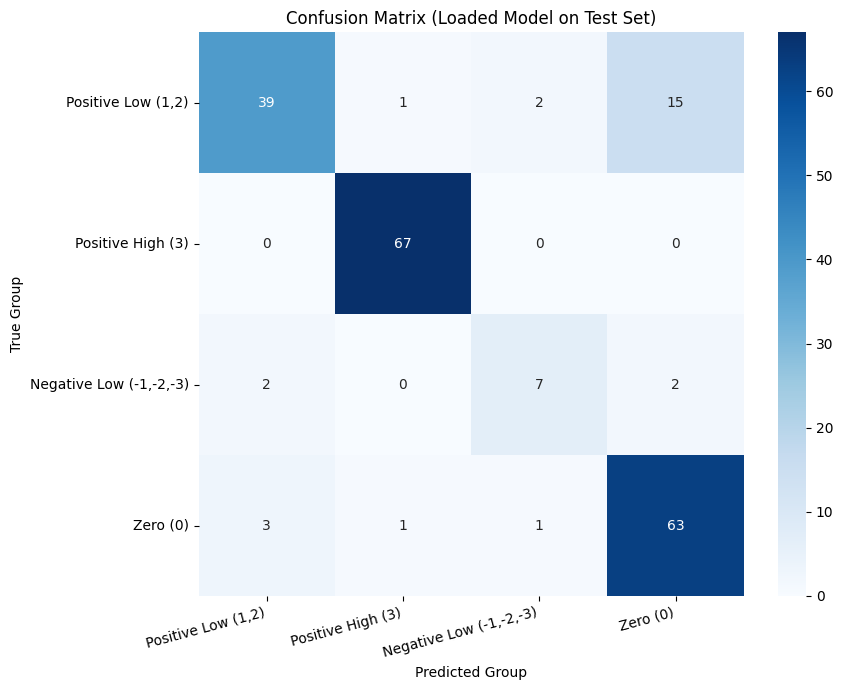

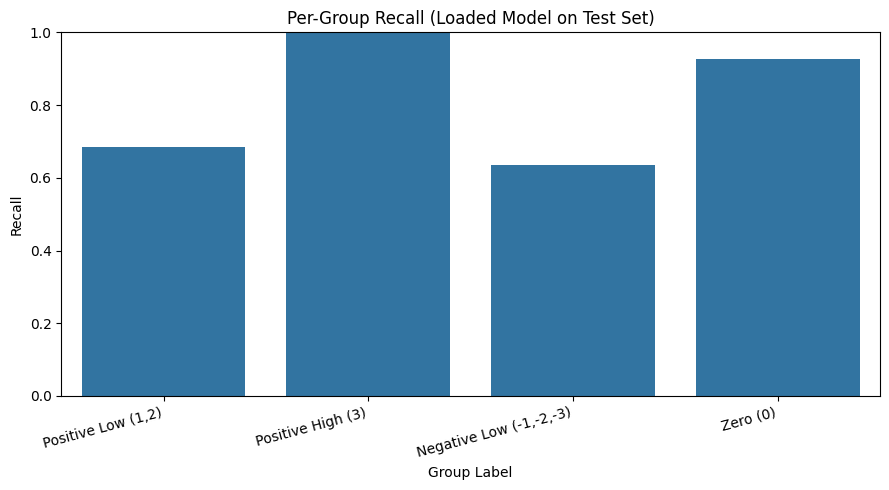

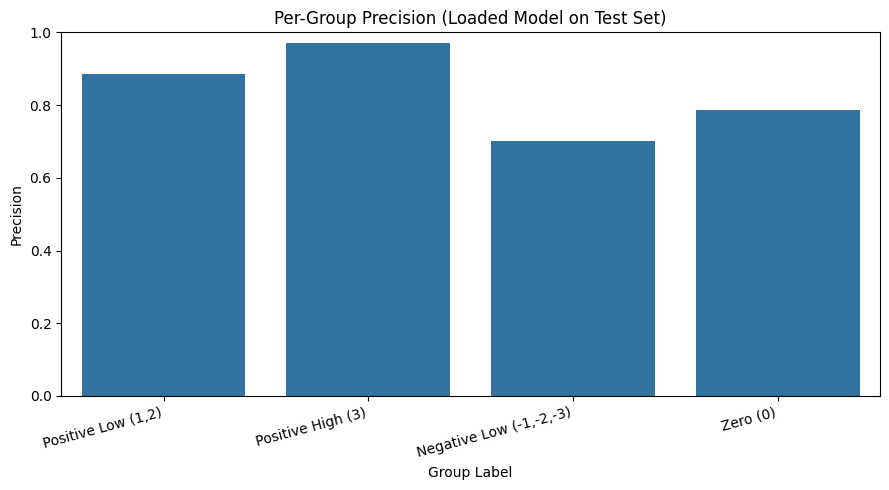

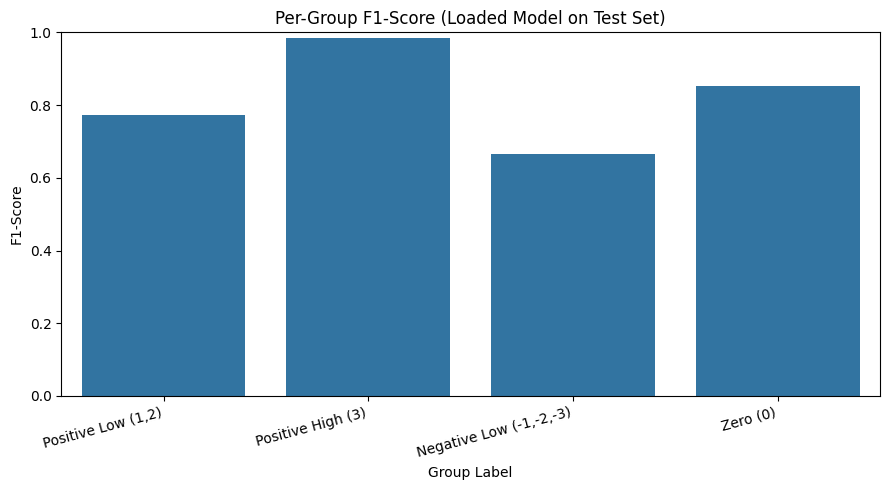

In [31]:
# --- 8. Load the Saved Model and Re-evaluate (Example) ---
# This section demonstrates how to load the saved model and artifacts
# for later use or verification.

print("\n--- Loading Saved Model and Artifacts for Re-evaluation ---")

# Define paths (should match the saving paths)
load_model_path = 'best_dna_bert_classifier_grouped.pth'
load_hyperparams_path = 'best_dna_bert_classifier_grouped_hyperparams.json'
load_label_encoder_path = 'grouped_label_encoder.joblib'

# Check if necessary components from previous steps exist
required_vars = ['X_test_tensor', 'y_test_tensor', 'device', 'num_classes', 'target_names_grouped']
if all(var in locals() or var in globals() for var in required_vars):
    try:
        # --- Load Hyperparameters ---
        import json
        with open(load_hyperparams_path, 'r') as f:
            loaded_best_params = json.load(f)
        print(f"Loaded hyperparameters from: {load_hyperparams_path}")
        print(f"Loaded params: {loaded_best_params}")

        # --- Load Label Encoder ---
        import joblib
        loaded_le_grouped = joblib.load(load_label_encoder_path)
        print(f"Loaded LabelEncoder from: {load_label_encoder_path}")
        # Verify loaded classes match
        if not np.array_equal(loaded_le_grouped.classes_, np.arange(num_classes)):
             print(f"Warning: Loaded LabelEncoder classes {loaded_le_grouped.classes_} might not match expected classes {np.arange(num_classes)}")
        # Re-derive target names from loaded encoder for consistency
        loaded_target_names_grouped = [grouped_class_names.get(i, f'Unknown Group {i}') for i in loaded_le_grouped.classes_]


        # --- Instantiate Model with Loaded Hyperparameters ---
        loaded_input_dim = X_test_tensor.shape[1] # Get input dim from data
        loaded_hidden_dims = loaded_best_params.get('hidden_dims', [256]) # Default if missing
        loaded_dropout_rate = loaded_best_params.get('dropout_rate', 0.5) # Default if missing
        loaded_output_dim = len(loaded_le_grouped.classes_) # Use loaded encoder's classes

        # Ensure the DNABERTClassifier class definition is available
        if 'DNABERTClassifier' not in globals() and 'DNABERTClassifier' not in locals():
             raise NameError("DNABERTClassifier class definition not found. Cannot instantiate the model.")

        loaded_model = DNABERTClassifier(
            input_dim=loaded_input_dim,
            hidden_dims=loaded_hidden_dims,
            output_dim=loaded_output_dim,
            dropout_rate=loaded_dropout_rate
        )
        print(f"\nInstantiated model with loaded hyperparameters: input_dim={loaded_input_dim}, hidden_dims={loaded_hidden_dims}, output_dim={loaded_output_dim}, dropout={loaded_dropout_rate}")

        # --- Load Model State Dictionary ---
        loaded_model.load_state_dict(torch.load(load_model_path, map_location=device)) # map_location ensures correct device loading
        loaded_model.to(device)
        print(f"Loaded model state dictionary from: {load_model_path} and moved to {device}")

        # --- Prepare DataLoader for Test Set ---
        # Recreate test dataset and loader if not available, otherwise reuse test_loader
        if 'test_loader' not in locals() and 'test_loader' not in globals():
             print("Recreating test DataLoader...")
             load_test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
             load_batch_size = 32 # Or use batch_size if available
             load_test_loader = DataLoader(load_test_dataset, batch_size=load_batch_size, shuffle=False)
        else:
             print("Using existing test DataLoader.")
             load_test_loader = test_loader # Reuse existing loader

        # --- Evaluate the Loaded Model ---
        print("\nEvaluating the Loaded Model on the Test Set...")
        loaded_model.eval() # Set the loaded model to evaluation mode
        y_pred_loaded_list = []
        y_true_loaded_list = []

        with torch.no_grad():
            for inputs, labels in tqdm(load_test_loader, desc="Evaluating Loaded Model"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = loaded_model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                y_pred_loaded_list.extend(predicted.cpu().numpy())
                y_true_loaded_list.extend(labels.cpu().numpy())

        y_pred_loaded_nn = np.array(y_pred_loaded_list)
        y_test_loaded_nn_eval = np.array(y_true_loaded_list)

        # --- Display Evaluation Metrics for Loaded Model ---
        accuracy_loaded_nn = accuracy_score(y_test_loaded_nn_eval, y_pred_loaded_nn)
        print(f"\nTest Accuracy (Loaded Model): {accuracy_loaded_nn:.4f}")

        print("\nClassification Report (Loaded Model):")
        # Use loaded target names derived from the loaded encoder
        print(classification_report(y_test_loaded_nn_eval, y_pred_loaded_nn, labels=loaded_le_grouped.classes_, target_names=loaded_target_names_grouped, zero_division=0))

        print("\nConfusion Matrix (Loaded Model):")
        cm_loaded = confusion_matrix(y_test_loaded_nn_eval, y_pred_loaded_nn, labels=loaded_le_grouped.classes_)

        # Calculate per-class metrics directly
        precision_loaded, recall_loaded, f1_loaded, support_loaded = precision_recall_fscore_support(
            y_test_loaded_nn_eval, y_pred_loaded_nn, labels=loaded_le_grouped.classes_, zero_division=0
        )

        print("\nPer-Group Metrics (Loaded Model on Test Set):")
        metrics_loaded_df = pd.DataFrame({
            'Group': loaded_target_names_grouped,
            'Precision': precision_loaded,
            'Recall': recall_loaded,
            'F1-Score': f1_loaded,
            'Support': support_loaded
        })
        pd.options.display.float_format = '{:.4f}'.format
        print(metrics_loaded_df.to_string(index=False))
        pd.reset_option('display.float_format')

        # --- Generate Plots for Loaded Model Evaluation ---
        try:
            import seaborn as sns
            import matplotlib.pyplot as plt

            # Confusion Matrix Heatmap
            plt.figure(figsize=(9, 7))
            sns.heatmap(cm_loaded, annot=True, fmt='d', cmap='Blues',
                        xticklabels=loaded_target_names_grouped, yticklabels=loaded_target_names_grouped)
            plt.xlabel('Predicted Group')
            plt.ylabel('True Group')
            plt.title('Confusion Matrix (Loaded Model on Test Set)')
            plt.xticks(rotation=15, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

            # Per-class Recall Bar Plot
            plt.figure(figsize=(9, 5))
            sns.barplot(x=loaded_target_names_grouped, y=recall_loaded)
            plt.xlabel('Group Label')
            plt.ylabel('Recall')
            plt.title('Per-Group Recall (Loaded Model on Test Set)')
            plt.ylim(0, 1)
            plt.xticks(rotation=15, ha='right')
            plt.tight_layout()
            plt.show()

            # Per-class Precision Bar Plot
            plt.figure(figsize=(9, 5))
            sns.barplot(x=loaded_target_names_grouped, y=precision_loaded)
            plt.xlabel('Group Label')
            plt.ylabel('Precision')
            plt.title('Per-Group Precision (Loaded Model on Test Set)')
            plt.ylim(0, 1)
            plt.xticks(rotation=15, ha='right')
            plt.tight_layout()
            plt.show()

            # Per-class F1-Score Bar Plot
            plt.figure(figsize=(9, 5))
            sns.barplot(x=loaded_target_names_grouped, y=f1_loaded)
            plt.xlabel('Group Label')
            plt.ylabel('F1-Score')
            plt.title('Per-Group F1-Score (Loaded Model on Test Set)')
            plt.ylim(0, 1)
            plt.xticks(rotation=15, ha='right')
            plt.tight_layout()
            plt.show()

        except ImportError:
            print("\nSeaborn or Matplotlib not installed. Skipping heatmap and bar plot visualization for loaded model.")
            print("Confusion Matrix (row=True, col=Predicted):")
            print(pd.DataFrame(cm_loaded, index=loaded_target_names_grouped, columns=loaded_target_names_grouped))
        except Exception as e:
            print(f"\nAn error occurred during plotting: {e}")

    except FileNotFoundError as e:
        print(f"\nError loading files: {e}. Make sure the model, hyperparameters, and label encoder were saved correctly in the previous step.")
    except NameError as e:
         print(f"\nError: {e}. Ensure necessary variables or class definitions are available.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during model loading or evaluation: {e}")

else:
    print("\nSkipping model loading and re-evaluation: Required variables (e.g., test data, device) not found.")
    missing = [var for var in required_vars if not (var in locals() or var in globals())]
    print(f"Missing variables: {missing}")



--- Creating Visualizations with Updated Class Labels ---


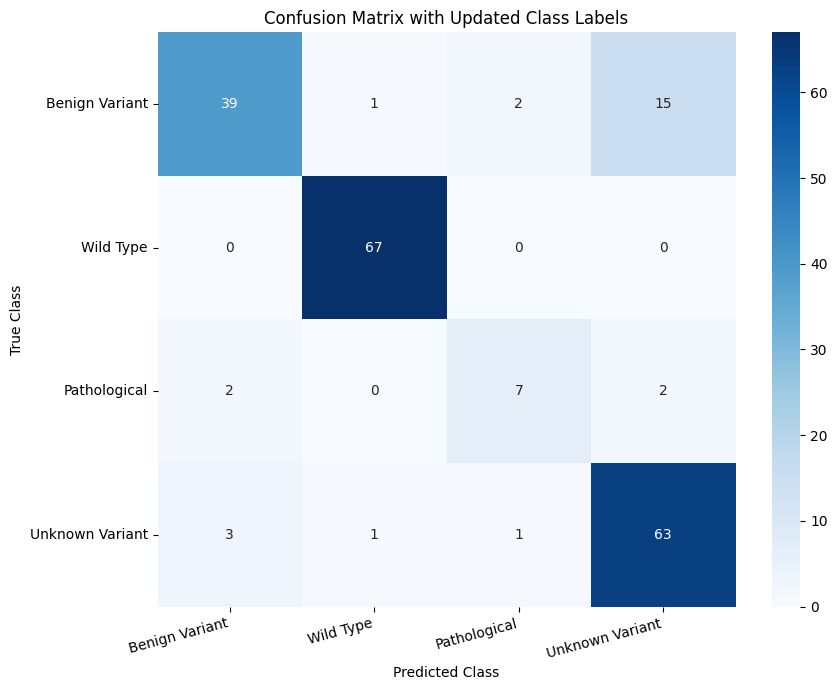

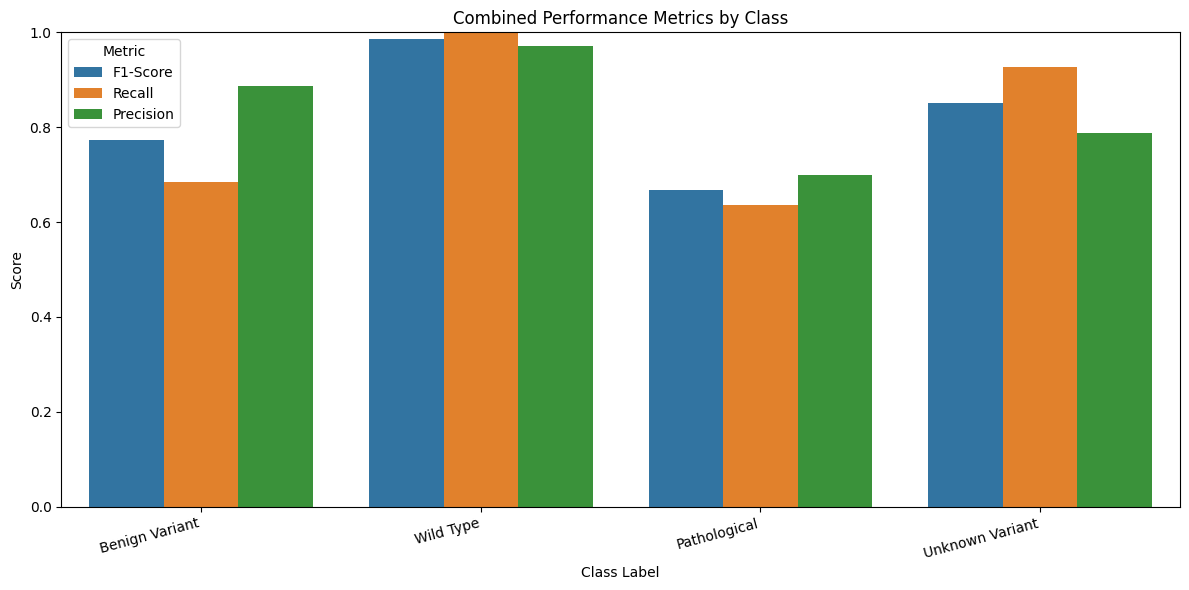

In [33]:
# --- 9. Visualize Results with Updated Labels ---
# This section creates visualizations with updated class labels

print("\n--- Creating Visualizations with Updated Class Labels ---")

try:
    # Define the updated class labels mapping
    updated_labels = {
        'Positive Low (1,2)': 'Benign Variant',
        'Positive High (3)': 'Wild Type',
        'Negative Low (-1,-2,-3)': 'Pathological',
        'Zero (0)': 'Unknown Variant'
    }
    
    # Map the original target names to the updated labels
    updated_target_names = [updated_labels.get(name, name) for name in loaded_target_names_grouped]
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Confusion Matrix with Updated Labels
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm_loaded, annot=True, fmt='d', cmap='Blues',
                xticklabels=updated_target_names, yticklabels=updated_target_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix with Updated Class Labels')
    plt.xticks(rotation=15, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Combined Metrics Bar Plot (F1, Recall, Precision)
    plt.figure(figsize=(12, 6))
    
    # Create a DataFrame for the combined metrics
    metrics_df = pd.DataFrame({
        'Class': updated_target_names,
        'F1-Score': f1_loaded,
        'Recall': recall_loaded,
        'Precision': precision_loaded
    })
    
    # Melt the DataFrame for easier plotting
    melted_df = pd.melt(metrics_df, id_vars=['Class'], 
                        value_vars=['F1-Score', 'Recall', 'Precision'],
                        var_name='Metric', value_name='Value')
    
    # Create the grouped bar plot
    sns.barplot(x='Class', y='Value', hue='Metric', data=melted_df)
    plt.xlabel('Class Label')
    plt.ylabel('Score')
    plt.title('Combined Performance Metrics by Class')
    plt.ylim(0, 1)
    plt.xticks(rotation=15, ha='right')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()
    
except NameError as e:
    print(f"\nError: {e}. Make sure the model evaluation has been completed.")
except Exception as e:
    print(f"\nAn error occurred during visualization with updated labels: {e}")
